# Анализ вложений в рекламу и полученных убытков на примере работы развлекательного приложения

**Введение**
У нас имеются данные о пользователях, их покупках и расходах на рекламу в отношении развлекательного приложения Procrastinate Pro+. По имеющейся информации компания на протяжении последних нескольких месяцев терпит убытки. Необходимо выяснить, в чём может быть причина. Данные хранятся в файлах `visits_info_short.csv` (данные о посещениях пользователей), `orders_info_short.csv` (данные о покупках), `costs_info_short.csv` (данные о расходах на рекламу).
Итак, наша цель:
- выяснить откуда приходят пользователи (в плане региона, устройств и источников, через которые они привлекаются)
- выяснить сколько стоит привлечение этих пользователей
- узнать сколько приносят дохода каждый пользователь
- когда реклама и в каких случая окупается и, если не окупается, то по каким возможным причинам.

План действий:
- ознакомимся с данными и проверим их, проведём предобработку
- зададим функции, которые помогут в анализе
- проведём исследовательский анализ данных
- рассмотрим структуру и динамику затрат на рекламу
- проверим окупаемость рекламы по различным категориям и возможные причины неокупаемости

## Загрузка данных и подготовка к анализу

### Знакомство с данными

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt


In [2]:
# выгрузка данных
visits = pd.read_csv('C:\\Users\\Marat\\Documents\\Marat\\data_analyse\projects\\analysis_entertaining _app\\visits_info_short.csv')
orders = pd.read_csv('C:\\Users\\Marat\\Documents\\Marat\\data_analyse\\projects\\analysis_entertaining _app\\orders_info_short.csv')
costs = pd.read_csv('C:\\Users\\Marat\\Documents\\Marat\\data_analyse\\projects\\analysis_entertaining _app\\costs_info_short.csv')

display(visits.head(10))
display(orders.head(10))
costs.head(10)

,User Id,Region,Device,Channel,Session Start,Session End
0,981449118918,United States,iPhone,organic,2019-05-01 02:36:01,2019-05-01 02:45:01
1,278965908054,United States,iPhone,organic,2019-05-01 04:46:31,2019-05-01 04:47:35
2,590706206550,United States,Mac,organic,2019-05-01 14:09:25,2019-05-01 15:32:08
3,326433527971,United States,Android,TipTop,2019-05-01 00:29:59,2019-05-01 00:54:25
4,349773784594,United States,Mac,organic,2019-05-01 03:33:35,2019-05-01 03:57:40
5,90242400005,United States,iPhone,RocketSuperAds,2019-05-01 07:14:52,2019-05-01 08:19:56
6,43958116050,United States,Android,organic,2019-05-01 09:03:21,2019-05-01 10:08:39
7,185365244969,United States,iPhone,organic,2019-05-01 09:37:03,2019-05-01 10:00:43
8,446013509831,United States,iPhone,RocketSuperAds,2019-05-01 10:26:00,2019-05-01 10:59:17
9,100970711362,United States,Mac,TipTop,2019-05-01 04:39:53,2019-05-01 04:57:05


,User Id,Event Dt,Revenue
0,188246423999,2019-05-01 23:09:52,4.99
1,174361394180,2019-05-01 12:24:04,4.99
2,529610067795,2019-05-01 11:34:04,4.99
3,319939546352,2019-05-01 15:34:40,4.99
4,366000285810,2019-05-01 13:59:51,4.99
5,129100331057,2019-05-01 01:56:28,4.99
6,626807144131,2019-05-01 02:39:21,4.99
7,914062168985,2019-05-01 02:02:18,4.99
8,769669137453,2019-05-01 03:39:47,4.99
9,434198630691,2019-05-01 18:16:50,5.99


,dt,Channel,costs
0,2019-05-01,FaceBoom,113.3
1,2019-05-02,FaceBoom,78.1
2,2019-05-03,FaceBoom,85.8
3,2019-05-04,FaceBoom,136.4
4,2019-05-05,FaceBoom,122.1
5,2019-05-06,FaceBoom,118.8
6,2019-05-07,FaceBoom,101.2
7,2019-05-08,FaceBoom,100.1
8,2019-05-09,FaceBoom,93.5
9,2019-05-10,FaceBoom,104.5


Мы имеем на руках три датасета:
- `visits` с информацией о посещениях.
- `orders` с информацией о покупках
- `costs` с информацией о затратах на маркетинг
  
Рассмотрим каждый датасет подробнее.

In [3]:
visits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 309901 entries, 0 to 309900
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   User Id        309901 non-null  int64 
 1   Region         309901 non-null  object
 2   Device         309901 non-null  object
 3   Channel        309901 non-null  object
 4   Session Start  309901 non-null  object
 5   Session End    309901 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.2+ MB


По датасету `visits` можно сделать следующие наблюдения:
- 6 столбцов: уникальный ID пользователя, страна пользователя, тип устройства пользователя, источник перехода, начало и конец сессии 
- некорректная стилистика наименования столбцов - лучше исправить.
- пропуски отсутствуют
- у столбцов `Session Start` и `Session End` тип данных "object" - исправить на datetime.
- необходимо проверить датасет на  явные, а также столбцы `Region`, `Device` и `Channel` на неявные дубликаты

In [4]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   User Id   40212 non-null  int64  
 1   Event Dt  40212 non-null  object 
 2   Revenue   40212 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 942.6+ KB


По датасету `orders` можно сделать следующие наблюдения:

- 3 столбца: уникальный ID пользователя, дата и вермя покупки, сумма заказа.
- некорректная стилистика наименования столбцов - лучше исправить.
- пропуски отсутствуют
- у столбца `Event Dt` тип данных "object" - исправить на datetime.
- необходимо проверить датасет на явные дубликаты

In [5]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1800 entries, 0 to 1799
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   dt       1800 non-null   object 
 1   Channel  1800 non-null   object 
 2   costs    1800 non-null   float64
dtypes: float64(1), object(2)
memory usage: 42.3+ KB


По датасету `costs` можно сделать следующие наблюдения:

- 3 столбца: дата проведения рекламной компании, идентификатор рекламного источника, расходы на рекламную компанию.
- некорректная стилистика наименования столбцов - лучше исправить.
- пропуски отсутствуют
- у столбца `dt` тип данных "object" - исправить на datetime.
- необходимо проверить датасет на явные дубликаты

### Предобработка

#### Исправим название столбцов

In [6]:
visits = visits.rename(columns={'User Id': 'user_id', 'Region': 'region', 'Device': 'device',
                                'Channel': 'channel', 'Session Start': 'session_start', 'Session End': 'session_end'})
visits.columns

Index(['user_id', 'region', 'device', 'channel', 'session_start',
       'session_end'],
      dtype='object')

In [7]:
orders = orders.rename(columns={'User Id': 'user_id', 'Event Dt': 'event_dt', 'Revenue': 'revenue'})
orders.columns

Index(['user_id', 'event_dt', 'revenue'], dtype='object')

In [8]:
costs = costs.rename(columns={'Channel': 'channel'})
costs.columns

Index(['dt', 'channel', 'costs'], dtype='object')

#### Изменим формат данных в столбцах с датами

In [9]:
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date

#### Проверка на дубликаты

Сначала проверим в датасете `visits` неявные дубликаты в столбцах `region`, `device`, `channel`

In [10]:
visits['region'].unique()

array(['United States', 'UK', 'France', 'Germany'], dtype=object)

В столбце `region` указаны четыре страны. Неявных дубликатов нет.

In [11]:
visits['device'].unique()

array(['iPhone', 'Mac', 'Android', 'PC'], dtype=object)

Столбец `device` - четыре варианта устройств. Неявных дубликатов нет.

In [12]:
visits['channel'].unique()

array(['organic', 'TipTop', 'RocketSuperAds', 'YRabbit', 'FaceBoom',
       'MediaTornado', 'AdNonSense', 'LeapBob', 'WahooNetBanner',
       'OppleCreativeMedia', 'lambdaMediaAds'], dtype=object)

Столбец `channel` - 11 вариантов источников перехода. Неявных дубликатов нет.

In [13]:
costs['channel'].unique()

array(['FaceBoom', 'MediaTornado', 'RocketSuperAds', 'TipTop', 'YRabbit',
       'AdNonSense', 'LeapBob', 'OppleCreativeMedia', 'WahooNetBanner',
       'lambdaMediaAds'], dtype=object)

В датасете costs в столбце channel - 10 источников (по сравнению с visits отсутствует "organic", что логично). Неявных дубликатов нет

In [14]:
visits.duplicated().sum()

0

В датасете `visits` явных дубликатов нет.

In [15]:
orders.duplicated().sum()

0

В датасете `orders` явных дубликатов нет.

In [16]:
costs.duplicated().sum()

0

В датасете `costs` явных дубликатов нет.

### Итого:
- датасет 'visits' содержит данные о посещениях сервиса (6 столбцов - пользователь, страна, устройство, источник перехода, дата и время начала и конца сессии). Наименование столбцов приведены в более корректный стиль. Исправлен тип данных в столбцах с датами и временем. Дубликатов нет.
- датасет 'orders' содержит данные о покупках (3 столбца - пользователь, дата, сумма заказа). Наименование столбцов приведены в более корректный стиль. Исправлен тип данных в столбце с датой и временем. Дубликатов нет.
- датасет 'costs' содержит данные о затратах на маркетинг (3 столбца - дата, источник привлечения, сумма расходов на рекламную компанию). Наименование столбцов приведены в более корректный стиль. Исправлен тип данных в столбце с датой. Дубликатов нет.

## Функции для расчёта и анализа LTV, ROI, удержания и конверсии.
(использованы функции, которые рассчитывались в теоретических уроках).

Это функции для вычисления значений метрик:

- `get_profiles()` — для создания профилей пользователей,
- `get_retention()` — для подсчёта Retention Rate,
- `get_conversion()` — для подсчёта конверсии,
- `get_ltv()` — для подсчёта LTV.

А также функции для построения графиков:

- `filter_data()` — для сглаживания данных,
- `plot_retention()` — для построения графика Retention Rate,
- `plot_conversion()` — для построения графика конверсии,
- `plot_ltv_roi` — для визуализации LTV и ROI.

Функция для создания профилей пользователей:

In [17]:
def get_profiles(sessions, orders, events, ad_costs, event_names=[]):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # добавляем флаги для всех событий из event_names
    for event in event_names:
        if event in events['event_name'].unique():
            profiles[event] = profiles['user_id'].isin(
                events.query('event_name == @event')['user_id'].unique()
            )

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

Функции для расчёта удержания:

In [18]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1)
        
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

функция конверсии:

In [19]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

функция для подсчёта LTV

In [20]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

Функции для построения графиков

In [21]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df 

In [22]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [23]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

In [24]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show() 

## Исследовательский анализ данных

- Составим профили пользователей. Определим минимальную и максимальную даты привлечения пользователей.
- Выясним, из каких стран пользователи приходят в приложение и на какую страну приходится больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих из каждой страны.
- Узнаем, какими устройствами пользуются клиенты и какие устройства предпочитают платящие пользователи. Построим таблицу, отражающую количество пользователей и долю платящих для каждого устройства.
- Изучим рекламные источники привлечения и определите каналы, из которых пришло больше всего платящих пользователей. Построим таблицу, отражающую количество пользователей и долю платящих для каждого канала привлечения.

После каждого пункта сделаем выводы.

### Профили пользователей.

In [25]:
events = None # других событий у нас не имеется.
profiles = get_profiles(visits, orders, events, costs)
profiles.head()

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [26]:
min_date = profiles['dt'].min()
max_date = profiles['dt'].max()
print('минимальная дата привлечения пользователей:', min_date)
print('самая поздняя дата привлечения пользователей:', max_date)

минимальная дата привлечения пользователей: 2019-05-01
самая поздняя дата привлечения пользователей: 2019-10-27


Т.е. мы имеем данные по пользователям, которых удалось привлечь почти за полгода, начиная с мая 2019 года.

In [27]:
profiles['payer'].mean()

0.05920350914617887

Доля платящих пользователей - всего около 6%

### Анализ по странам.

In [28]:
profiles['region'].unique()

array(['United States', 'France', 'Germany', 'UK'], dtype=object)

Т.е. новые пользователи приходят из 4-х стран: США, Франции, Германии и Великобритании.   
Посмотрим подробнее.

,quantity_users,quantity_payer,share_of_payers
region,,,
France,17450,663,3.80%
Germany,14981,616,4.11%
UK,17575,700,3.98%
United States,100002,6902,6.90%


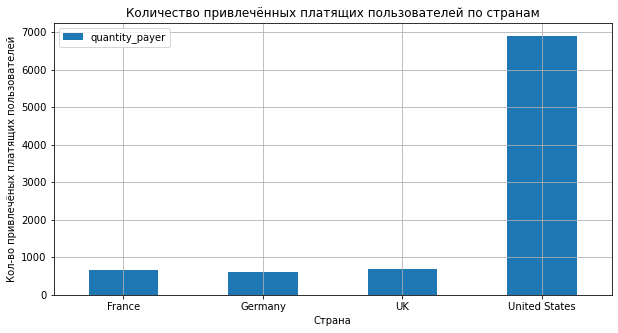

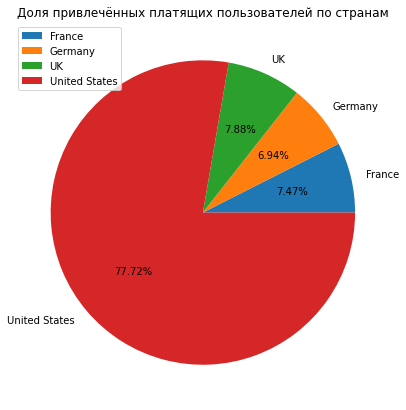

In [29]:
region_users = (
    profiles.groupby('region')
    .agg({'user_id': 'count', 'payer': 'sum'})
    .rename(columns={'user_id': 'quantity_users', 'payer': 'quantity_payer'})
)
# доля платящих пользователей по каждой стране.
region_users['share_of_payers'] = region_users['quantity_payer'] / region_users['quantity_users']
region_users['share_of_payers'] = region_users['share_of_payers'].apply(lambda x: "{0:.2f}%".format(100*x))
display(region_users)


region_users.plot(kind='bar', y='quantity_payer', figsize=(10, 5), grid=True)
plt.ylabel('Кол-во привлечёных платящих пользователей')
plt.xlabel('Страна')
plt.xticks(rotation = 0)
plt.title('Количество привлечённых платящих пользователей по странам')
plt.show()


region_users.plot(kind='pie', y='quantity_payer', figsize=(7, 7), autopct='%1.2f%%')
plt.title('Доля привлечённых платящих пользователей по странам')
plt.ylabel('')
plt.show()

Больше всего новых пользователей за рассматриваемый период (с мая 2019года по октябрь 2019) приходится на США - 100002 пользователей. У остальных стран количество привлечённых пользователей существенно меньше (на каждую приходится примерно по 15-17,5тыс. пользователей). В разрезе платящих пользователей наблюдается та же картина (на США - почти 7тыс. пользователей (77.72%), а на Францию, Германию и Великобританию всего по 600-700 человек (7-8%)).  
Кроме того, в США значительно больше и доля платящих пользователей по отношению к общему количеству привлечённых пользователей в стране - 6,90% (в остальных странах около 4%). Т.е. можно предположить, что в Европе пользователи хуже переходят в категорию платящих.

### По устройствам

In [30]:
profiles['device'].unique()

array(['Mac', 'iPhone', 'PC', 'Android'], dtype=object)

Основными устройствами, которые используют пользователи являются Mac, iphone, PC и устройства на Android.

,quantity_users,quantity_payer,share_of_payers
device,,,
Android,35032,2050,5.85%
Mac,30042,1912,6.36%
PC,30455,1537,5.05%
iPhone,54479,3382,6.21%


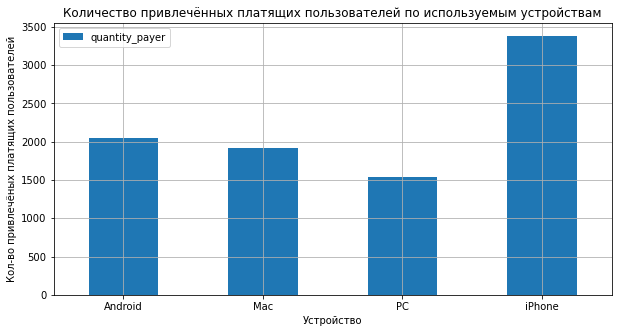

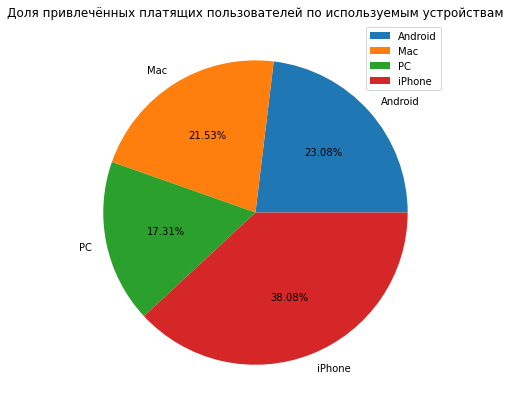

In [31]:
device_users = (
    profiles.groupby('device')
    .agg({'user_id': 'count', 'payer': 'sum'})
    .rename(columns={'user_id': 'quantity_users', 'payer': 'quantity_payer'})
)
# доля платящих пользователей по каждой стране.
device_users['share_of_payers'] = device_users['quantity_payer'] / device_users['quantity_users']
device_users['share_of_payers'] = device_users['share_of_payers'].apply(lambda x: "{0:.2f}%".format(100*x))
display(device_users)


device_users.plot(kind='bar', y='quantity_payer', figsize=(10, 5), grid=True)
plt.ylabel('Кол-во привлечёных платящих пользователей')
plt.xlabel('Устройство')
plt.xticks(rotation = 0)
plt.title('Количество привлечённых платящих пользователей по используемым устройствам')
plt.show()

device_users.plot(kind='pie', y='quantity_payer', figsize=(7, 7), autopct='%1.2f%%')
plt.title('Доля привлечённых платящих пользователей по используемым устройствам')
plt.ylabel('')
plt.show()

Чрезмерно сильного перекоса в пользу какого-то одного устройства среди привлекаемых пользователей нет. Однако наибольшее количество привлечённых пользователей использую iphone. При этом на другие устройства приходится также довольно большое количество пользователей. В разрезе платящих пользователей наблюдается схожая картина ("лидер" - также iphone - 38,08%).
Стоит отметить, что и по доле платящих пользователей на каждое из устройств в лидерах Mac и iphone (6,36% и 6,21%). Устройства на Android ниже -5,85%, а для PC - 5,05%

### Источники привлечения.

,quantity_users,quantity_payer,share_of_payers
channel,,,
FaceBoom,29144,3557,12.20%
TipTop,19561,1878,9.60%
organic,56439,1160,2.06%
WahooNetBanner,8553,453,5.30%
AdNonSense,3880,440,11.34%
RocketSuperAds,4448,352,7.91%
LeapBob,8553,262,3.06%
OppleCreativeMedia,8605,233,2.71%
lambdaMediaAds,2149,225,10.47%


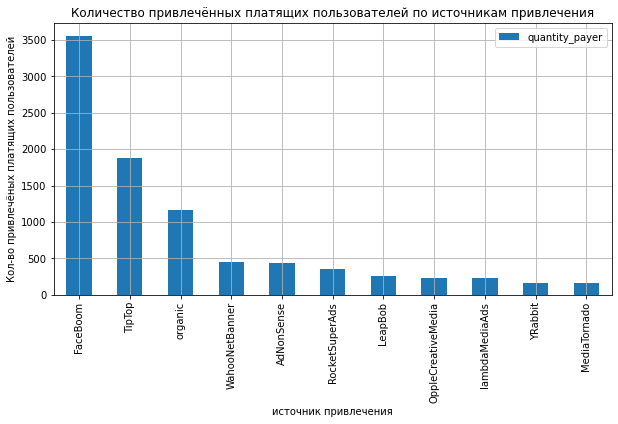

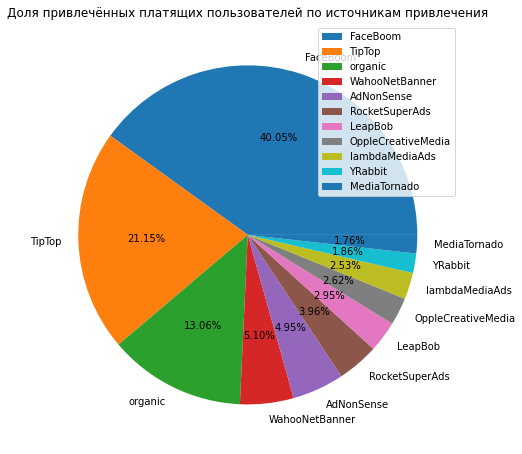

In [32]:
channel_users = (
    profiles.groupby('channel')
    .agg({'user_id': 'count', 'payer': 'sum'})
    .rename(columns={'user_id': 'quantity_users', 'payer': 'quantity_payer'})
    .sort_values(by='quantity_payer', ascending=False)
)
# доля платящих пользователей по каждой стране.
channel_users['share_of_payers'] = channel_users['quantity_payer'] / channel_users['quantity_users']
channel_users['share_of_payers'] = channel_users['share_of_payers'].apply(lambda x: "{0:.2f}%".format(100*x))
display(channel_users)


channel_users.plot(kind='bar', y='quantity_payer', figsize=(10, 5), grid=True)
plt.ylabel('Кол-во привлечёных платящих пользователей')
plt.xlabel('источник привлечения')
plt.title('Количество привлечённых платящих пользователей по источникам привлечения')
plt.show()

channel_users.plot(kind='pie', y='quantity_payer', figsize=(7, 7), autopct='%1.2f%%')
plt.title('Доля привлечённых платящих пользователей по источникам привлечения')
plt.ylabel('')
plt.tight_layout()
plt.show()

Итак: у нас имеется 10 источников,через которые идёт привлечение пользователей с помощью рекламы, а также "органические" пользователи, которые приходят самостоятельно.
Наибольшее количество пользователей приходят самостоятельно (Organic - 56439 пользователей) и через FaceBoom (29144 пользователей) и TipTop (19561 пользователей). У остальных источников существенно меньше. Среди платящих пользователей наибольшее количество приходится на FaceBoom и TipTop (3557 и 1878 пользователей, 40.05% и 21,15%), у "органических" - 1160 пользователей (13,06%). Т.е. в категорию платящих пользователей переходит очень мало из "органических" (всего 2,06%). По доле платящих пользователей на каждый канал привлечения в "лидерах" - FaceBoom (12,20%), AdNonSense(11,34%), lambdaMediaAds (10,47%) и TipTop (9,60%). При этом у AdNonSense и lambdaMediaAds количество привлечённых пользователей совсем небольшое (суммарно 6029 пользователей).
В целом доли платящих пользователей на каждый из источников привлечения очень сильно разнятся (у 6 источников этот показатель ниже 4%). Возможно, стоит более подробно рассмореть вероятные причины такого сильного разброса процента платящих пользователей и низкого количества привлечённых пользователей у источников с хорошим процентом платящих (возможно, эти источники просто изначально не самые популярные).

### Итого:
- Привлекаются пользователи из 4-х стран: США, Великобритании, Франции и Германии. Больше всего пользователей из США. Также из этой страны больше всего и платящих пользователей (также и процент платящих к привлечённым - 6,90%, у остальных - около 4%).  
- Основные используемые устройства - iphone, Mac, PC и устройства на Android. Наибольшей популярностью среди платящих покупателей - iphone. Меньше всего пользователей используют PC. Доля платящих у iphone и Mac - выше 6%, у PC и Android - 5,05% и 5,85% соответственно
- имеется 10 источников привлечения, на которые направлен рекламный бюджет, а также "органические" пользователи, которые приходяти сами. Больше всего платящих пользователей приходится на FaceBoom и TipTop, а также много "органических". Наибольшая доля платящих среди привлечённых у FaceBoom (12,20%), AdNonSense(11,34%), lambdaMediaAds (10,47%) и TipTop (9,60%). При этом у AdNonSense и lambdaMediaAds количество привлечённых пользователей совсем небольшое (суммарно 6029 пользователей).Разброса процента платящих пользователей по отношению к привлечённым в разрезе источников привлечения очень сильный (от 2,02% до 12,2%)

## Маркетинг

- Посчитаем общую сумму расходов на маркетинг.
- Выясним, как траты распределены по рекламным источникам, то есть сколько денег потратили на каждый источник.
- Построим визуализацию динамики изменения расходов во времени (по неделям и месяцам) по каждому источнику.
- Узнаем, сколько в среднем стоило привлечение одного пользователя (CAC) из каждого источника. 


### Общая сумма на маркетинг

In [33]:
round(costs['costs'].sum(), 2)

105497.3

Т.е. почти за полгода (с мая по неполный октябрь) потрачено 105497,30 у.е.(валюта вроде нигде не указана. Можно предположить, что речь идёт о долларах США с учётом того, что больше всего пользователей приходит из этой страны)

### Общие затраты по рекламным источникам

Далее посмотрим общие траты по различным рекламным источникам за весь период данных.

In [34]:
costs_channel = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False)
costs_channel

,costs
channel,
TipTop,54751.30
FaceBoom,32445.60
WahooNetBanner,5151.00
AdNonSense,3911.25
OppleCreativeMedia,2151.25
RocketSuperAds,1833.00
LeapBob,1797.60
lambdaMediaAds,1557.60
MediaTornado,954.48


In [35]:
# посчитаем сумму расходов на "непопулярные" источники
costs_channel.query('channel != "TipTop" and channel != "FaceBoom"')['costs'].sum()

18300.4

В рассматриваемом периоде больше всего средств потрачено на привлечение пользователей через TipTop (54751,30 у.е.) и FaceBoom (32445,60 у.е.). При дальнейшем анализе стоит посмотреть на эти источники в первую очередь. При этом на все остальные источники приходится 18300,40 у.е. суммарно.  
Далее посмотрим, как менялись суммарные расходы по источникам с течением времени за данный период.

### Динамика изменения расходов по рекламным источникам

In [36]:
# добавим столбцы с номером недели и номером месяца.
costs['week'] = pd.to_datetime(costs['dt']).dt.isocalendar().week
costs['month'] = pd.to_datetime(costs['dt']).dt.month
costs.head()

,dt,channel,costs,week,month
0,2019-05-01,FaceBoom,113.3,18,5
1,2019-05-02,FaceBoom,78.1,18,5
2,2019-05-03,FaceBoom,85.8,18,5
3,2019-05-04,FaceBoom,136.4,18,5
4,2019-05-05,FaceBoom,122.1,18,5


In [37]:
# сделаем сводную таблицу по месяцам и источникам
channel_month = costs.pivot_table(index='month', columns='channel', values='costs', aggfunc='sum')
channel_month

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
month,,,,,,,,,,
5,1169.70,3524.4,140.28,238.56,169.75,577.980,2981.0,418.8,299.70,458.4
6,538.65,5501.1,314.58,138.00,370.00,325.715,6675.6,921.0,106.20,199.2
7,504.00,5294.3,313.53,138.48,366.50,252.070,8410.2,851.4,97.38,219.2
8,579.60,6274.4,369.81,154.56,439.25,253.110,11202.0,1040.4,124.74,220.0
9,581.70,6114.9,343.98,144.72,427.75,218.400,13232.5,977.4,152.79,247.2
10,537.60,5736.5,315.42,140.16,378.00,205.725,12250.0,942.0,163.41,213.6


In [38]:
# сделаем сводную таблицу по неделям и источникам
channel_week = costs.pivot_table(index='week', columns='channel', values='costs', aggfunc='sum')
channel_week.head()

channel,AdNonSense,FaceBoom,LeapBob,MediaTornado,OppleCreativeMedia,RocketSuperAds,TipTop,WahooNetBanner,YRabbit,lambdaMediaAds
week,,,,,,,,,,
18,211.05,535.7,16.80,38.64,24.00,99.450,347.0,49.2,52.2,81.6
19,273.00,750.2,31.71,61.68,34.50,139.230,470.0,92.4,75.9,103.2
20,265.65,755.7,26.67,59.04,27.50,138.060,454.0,90.0,69.3,90.4
21,266.70,722.7,26.67,50.16,34.25,131.040,801.8,79.2,65.4,119.2
22,202.65,1208.9,65.52,36.96,81.75,97.695,1421.2,179.4,49.8,83.2


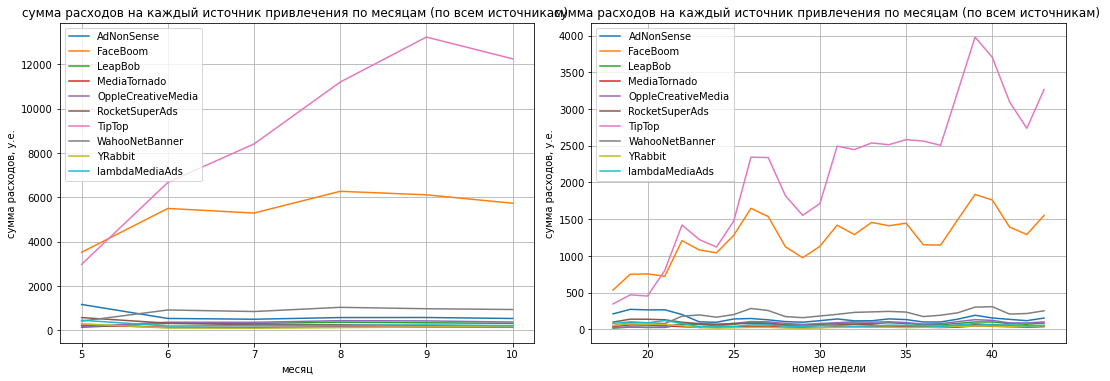

In [39]:
# пострим графики

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 2, 1)

channel_month.plot(grid=True, ax=ax1)
plt.legend()
plt.xlabel('месяц')
plt.ylabel('сумма расходов, у.е.')
plt.title('сумма расходов на каждый источник привлечения по месяцам (по всем источникам) ')

ax2 = plt.subplot(2, 2, 2)

channel_week.plot(grid=True, ax=ax2)
plt.legend()
plt.xlabel('номер недели')
plt.ylabel('сумма расходов, у.е.')
plt.title('сумма расходов на каждый источник привлечения по месяцам (по всем источникам) ')

plt.tight_layout()
plt.show() 


Итак по графикам видим, что самые большие средства тратятся на привлечение пользователей через TipTop, что может быть оправдано с учётом того, что это один из самых популярных источников. Также большие расходы и на FaceBoom. Стоит заметить, что FaceBoom привлёк за данный период больше пользователей (ровно как и больше платящих пользователей), чем TipTop, поэтому стоит в дальнейшем посмотреть, насколько оправданы такие высокие расходы на TipTop. Если же говорить о динамике, то на TipTop расходы выросли очень значительно - гораздо сильнее чем на FaceBoom (хотя и там замечен рост но незначительный). При этом в разрезе по неделям видно имеются периоды роста и снижения уровня расходов (возможно, есть влияние некой сезонности или наличия каких-то праздников на неделе). У остальных источников привлечения уровень расходов очень низкий (в разрезе по месяцам месяце - меньше 2000у.е., а по неделеям меньше 400у.е.). И существенного роста по сравнению с главными источниками не наблюдается. Далее рассмотрим их внимательнее.

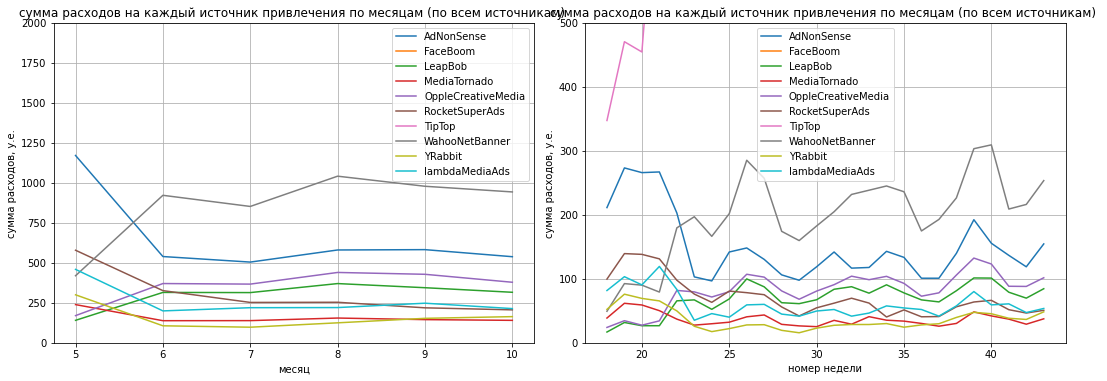

In [40]:
# пострим более внимательно графики для менее затратных и популярных источников.

plt.figure(figsize=(15, 10))

ax1 = plt.subplot(2, 2, 1)

channel_month.plot(grid=True, ax=ax1)
plt.legend()
plt.ylim(0,2000)
plt.xlabel('месяц')
plt.ylabel('сумма расходов, у.е.')
plt.title('сумма расходов на каждый источник привлечения по месяцам (по всем источникам) ')

ax2 = plt.subplot(2, 2, 2)

channel_week.plot(grid=True, ax=ax2)
plt.legend()
plt.ylim(0,500)
plt.xlabel('номер недели')
plt.ylabel('сумма расходов, у.е.')
plt.title('сумма расходов на каждый источник привлечения по месяцам (по всем источникам) ')

plt.tight_layout()
plt.show() 

При детальном рассмотрении менее затратных источников привлечения можно заметить, что немного подросли  расходы на WahooNetBanner, а на AdnonSense, RocketSuperAds и lambdaMediaAds расходы несколько снизились.  
Также снова видно, что в разрезе по неделям у большинства источников есть периоды роста и снижения уровня расходов (по большей части совпадающий с аналогичными периодами у основных источников TipTop и FaceBoom.  

### Стоимость привлечения одного пользователя из каждого источника

In [41]:
cac_channel = (
    profiles.groupby('channel')
    .agg({'acquisition_cost': 'mean'})
    .rename(columns={'acquisition_cost': 'cac'})
    .sort_values(by='cac', ascending=False)
)
display(cac_channel)
print('средний CAC:', round(cac_channel['cac'].mean(), 4))

,cac
channel,
TipTop,2.799003
FaceBoom,1.113286
AdNonSense,1.008054
lambdaMediaAds,0.724802
WahooNetBanner,0.602245
RocketSuperAds,0.412095
OppleCreativeMedia,0.250000
YRabbit,0.218975
MediaTornado,0.218717


средний CAC: 0.687


Получив среднюю стоимость привлечения одного пользователя по каналам привлечения за весь период, видим, что самыми дорогими (с большим отрывом) являются пользователи, которые пришли через TipTop - 2.799у.е. Причём стоимость пользователей от TipTop почти в 3 раза дороже пользователей от FaceBoom (1,113у.е.). На третьем месте идет AdNonSense - 1,008у.е., при этом общие затраты на AdNonSense существенно ниже чем на FaceBoom  и TipTop, и пользователей через этот источник приходит также значительно меньше.  
Самыми дешёвыми являются пользователи от YRabbit, MediaTornado, LeapBob	и OppleCreativeMedia (от 0,21у.е. до 0,25у.е.). 
"Органические" пользователи приходят бесплатно, поэтому напротив `organic` стоит `0`.

### Итого по разделу
- общая сумма расходов с мая 2019 по неполный октябрь (по 27.10.2019) - 105497,30 у.е  
- больше всего средств потрачено на привлечение пользователей через TipTop (54751,30 у.е.) и FaceBoom (32445,60 у.е.). На все остальные источники приходится 18300,40 у.е. суммарно 
- На TipTop расходы за указанный период выросли очень значительно - гораздо сильнее чем на FaceBoom (хотя и там замечен рост но незначительный). У остальных источников привлечения уровень расходов очень низкий (в разрезе по месяцам месяце - меньше 2000у.е., а по неделеям меньше 400у.е.). И существенного роста по сравнению с главными источниками не наблюдается.
- немного подросли расходы на WahooNetBanner, а на AdnonSense, RocketSuperAds и lambdaMediaAds расходы несколько снизились.  
- самыми дорогими (с большим отрывом) являются пользователи, которые пришли через TipTop - 2.799у.е.. Причём стоимость пользователей от TipTop почти в 3 раза дороже пользователей от FaceBoom (1,113у.е.). На третьем месте идет AdNonSense - 1,008у.е., при этом общие затраты на AdNonSense существенно ниже чем на FaceBoom и TipTop, и пользователей через этот источник приходит также значительно меньше.
- самые дешёвые пользователи - от YRabbit, MediaTornado, LeapBob и OppleCreativeMedia.

## Оценка окупаемость рекламы

Используя графики LTV, ROI и CAC, проанализируем окупаемость рекламы. Предполагаем, что на календаре 1 ноября 2019 года, а в бизнес-плане заложено, что пользователи должны окупаться не позднее чем через две недели после привлечения. 

- Проанализируем окупаемость рекламы c помощью графиков LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проверим конверсию пользователей и динамику её изменения. То же самое сделаем с удержанием пользователей. Построим и изучим графики конверсии и удержания.
- Проанализируем окупаемость рекламы с разбивкой по устройствам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по странам. Построим графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- Проанализируем окупаемость рекламы с разбивкой по рекламным каналам. Постройте графики LTV и ROI, а также графики динамики LTV, CAC и ROI.
- вопросы:
    - Окупается ли реклама, направленная на привлечение пользователей в целом?
    - Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
    - Чем могут быть вызваны проблемы окупаемости?


### Общая окупаемость рекламы

In [42]:
# уберём органических пользователей из профилей для оценки окупаемости рекламы
profiles = profiles.query('channel != "organic"')

# Получимм таблицы LTV и ROI и их динамики, с моментом анализа 01.11.2019 и горизонтом 14 дней.
horizon_days = 14
observation_date = datetime(2019, 11, 1).date()

result_raw, ltv, ltv_history, roi, roi_history = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days, 
    dimensions=[]
)


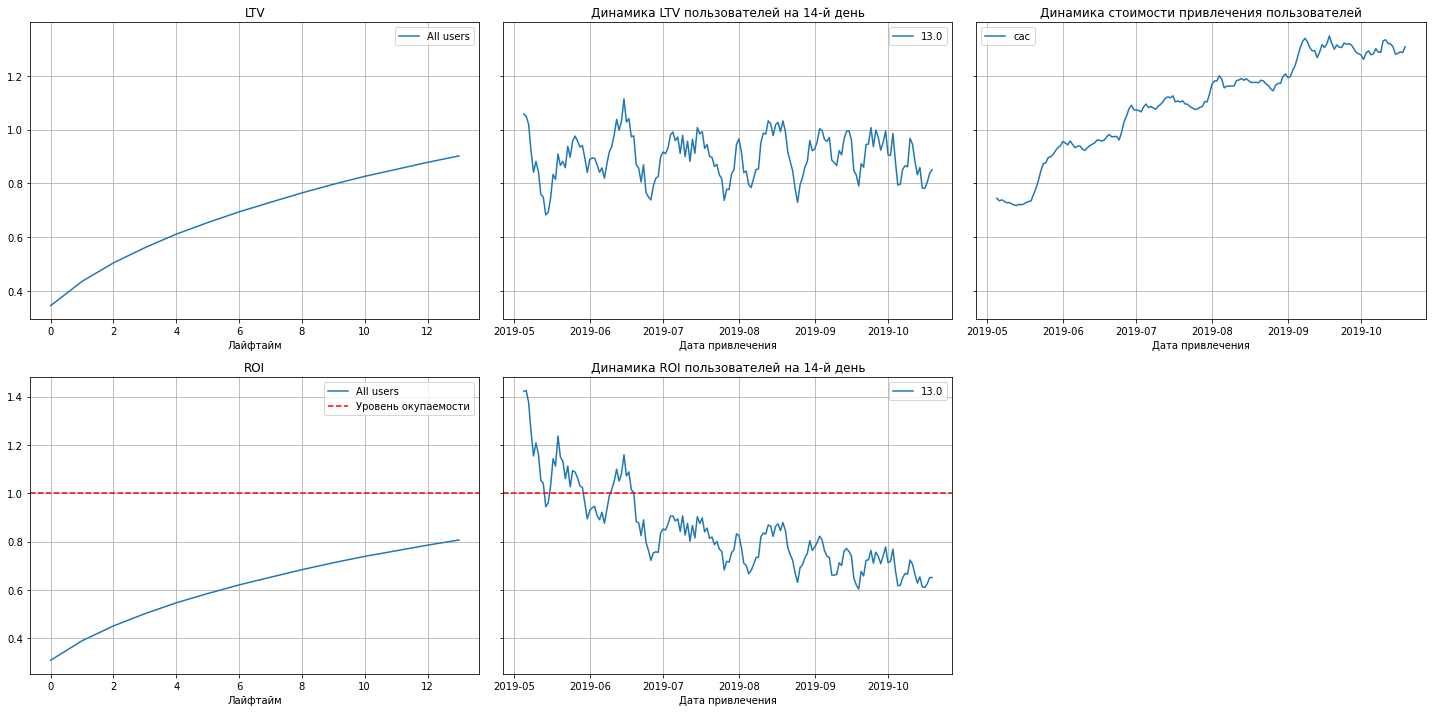

In [43]:
# выведем графики LTV, ROI, а также динамики LTV, CAC и ROI

plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon_days, window=5)

Что можно видеть по графикам:
- реклама не окупается. К концу второй недели ROI пользователя не дотягивается до единицы (еле перешагнул 0,8).
- кроме того, за рассматриваемые полгода уровень ROI на 14-й день постоянно падает (в мае-июне реклама ещё окупалась).
- LTV подвержен колебаниям, но тенденции к снижению нет.
- можно видеть, что с середины мая очень сильно начали расти затраты на рекламу. CAC продолжает расти и дальше. 

### Конверсия и удержание

In [44]:
# расчёт конверсии
result_raw, conversion, conv_history = get_conversion(profiles,
                                                     orders,
                                                     observation_date,
                                                     horizon_days,
                                                     dimensions=[]
                                                     )
conversion

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
cohort,,,,,,,,,,,,,,,
All users,88644,0.058752,0.066321,0.069999,0.072571,0.0745,0.075775,0.076745,0.077591,0.078291,0.078945,0.079362,0.079678,0.079904,0.080197


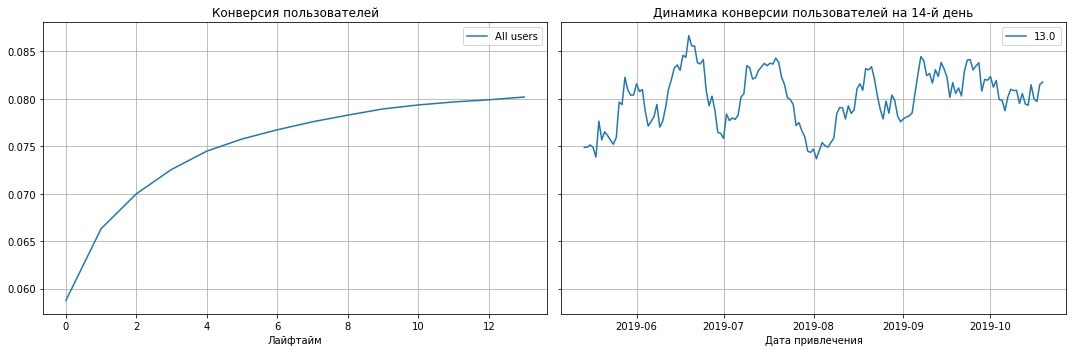

In [45]:
# построим графики
plot_conversion(conversion, conv_history, horizon_days, window=14)

В общем, в покупатели конвертируется чуть менее 6% привлечённых пользователей в первый день использования приложения и около 8% к 14-му дню. Вероятно, нельзя сказать что за 14 дней это очень серьёзный рост числа пользователей перешедших в разряд поупателей.
Конверсия в целом в рассматриваемом периоде в отдельно взятые промежутки подросла по сравнению с маем и июнем и держится примерно на одном уровне, хотя имеются колебания.

Далее посмотрим удержание

In [46]:
result_raw, retention, ret_history = get_retention(profiles,
                                                     visits,
                                                     observation_date,
                                                     horizon_days,
                                                     dimensions=[]
                                                     )
retention

,cohort_size,0,1,2,3,4,5,6,7,8,9,10,11,12,13
payer,,,,,,,,,,,,,,,
False,81334,1.0,0.176876,0.086594,0.051823,0.033504,0.024701,0.018651,0.014188,0.011729,0.009541,0.007488,0.006393,0.006012,0.004709
True,7310,1.0,0.380985,0.293023,0.235568,0.210260,0.191245,0.166758,0.156908,0.145144,0.136389,0.135021,0.121888,0.118741,0.104925


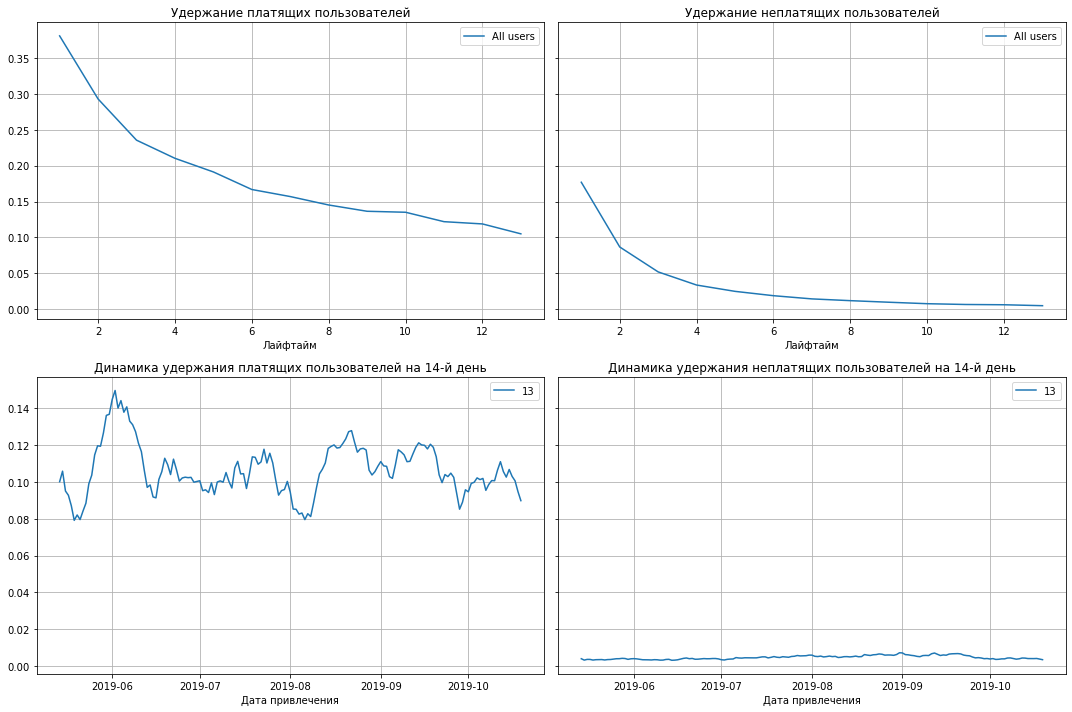

In [47]:
# построим графики
plot_retention(retention, ret_history, horizon_days, window=14)

Итак, очевидно, что платящие пользователи удерживаются значительно лучше, чем неплатящие. На второй день из платящих пользователей остаётся чуть меньше 40%, а на 14-й день чуть больше 10% (наверно, было бы лучше, чтобы снижение было ещё более пологое). При этом в динамике видно, что удержание платящих пользователей на 14-й день за полгода принципиально не изменилось.  
В тоже время удержание неплатящих пользователей на второй день уже чуть меньше 18%, а к 10 дню уже меньше одного процента и устремляется к нулю (на 14-й день - 0,46%). На это однозначно стоит обратить внимание, ведь чем лучше удерживаются неплатящие пользователи, тем с большей вероятностью они перейдут в категорию платящих.


### Разбивка по устройствам

In [48]:
# LTV,ROI, CAC и динамика по устройствам
result_raw, ltv_devices, ltv_history_devices, roi_devices, roi_history_devices = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days, 
    dimensions=['device']
)
display(ltv_devices)
roi_devices

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,
Android,20683,0.339218,0.430766,0.500209,0.555218,0.608159,0.661395,0.699810,0.738562,0.773986,0.806850,0.833871,0.856068,0.887970,0.912098
Mac,17747,0.382235,0.480219,0.550124,0.605077,0.651197,0.685782,0.721831,0.752874,0.790957,0.825376,0.857376,0.884370,0.904617,0.930541
PC,18128,0.277400,0.361536,0.430422,0.485652,0.539617,0.581623,0.631240,0.661959,0.701004,0.729414,0.761510,0.788708,0.812106,0.836167
iPhone,32086,0.367928,0.456307,0.523902,0.583165,0.632132,0.673563,0.710708,0.749656,0.779956,0.812214,0.840427,0.867426,0.894400,0.916983


,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,,
Android,20683,1.019759,0.332645,0.422419,0.490517,0.544460,0.596376,0.648580,0.686250,0.724251,0.758989,0.791216,0.817714,0.839481,0.870765,0.894425
Mac,17747,1.276219,0.299506,0.376283,0.431058,0.474117,0.510255,0.537354,0.565601,0.589926,0.619766,0.646735,0.671809,0.692961,0.708825,0.729139
PC,18128,0.792724,0.349933,0.456068,0.542966,0.612637,0.680712,0.733701,0.796291,0.835044,0.884297,0.920135,0.960624,0.994933,1.024449,1.054801
iPhone,32086,1.277021,0.288114,0.357321,0.410253,0.456661,0.495005,0.527449,0.556536,0.587035,0.610762,0.636023,0.658115,0.679258,0.700380,0.718064


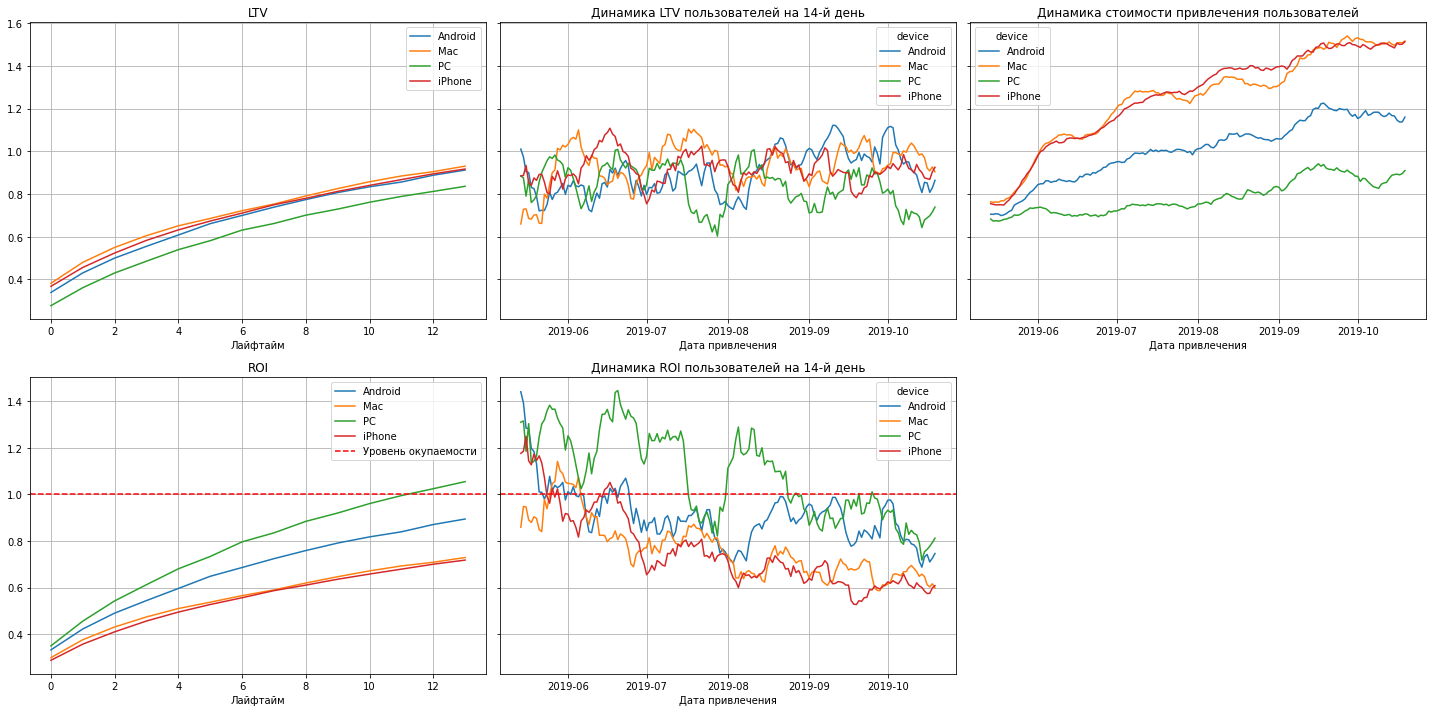

In [49]:
# графики

plot_ltv_roi(ltv_devices, ltv_history_devices, roi_devices, roi_history_devices, horizon_days, window=14)

Итак, при разбивке по используемым устройствам:
- в целом LTV для Mac, iphone и устройств на Android примерно одинаковый (на 14-й день LTV пользователя в районе 0,9у.е.). Чуть ниже LTV у пользователей с PC (где-то в районе 0,85у.е).  
- в целом за весь период LTV 14-го дня к середине июня остаётся примерно на одном уровне по всем устройствам, но сильно колеблется, хоть и с разными периодами для разных устройств (особенно сильно колеблется LTC для пользователей PC - сильное падение в конце июля).
- по графику ROI можно сделать однозначный вывод, что пользователи на устройствах Mac и iphone за 14 дней не окупаются совсем (не дотягивают даже до 0,8). Также не окупаются и пользователи на Android (ROi под конец второй недели - около 0,9). В целом окупаются клиенты на PC, но только на 12-й день. Вспоминая, что на iphone, Mac и Android суммарно приходится очень большая доля платящих покупателей, то их неокупаемость обходится очень дорого.
- в динамике видно, что ранее (в мае) ситуация была лучше, разве что Mac был в минусе (Пользователи остальных устройств окупались). Однако сейчас видно, что есть по всем тенденция к снижению. Быстрее всего в "минус" ушли именно Mac и iphone. К ним быстро присоединился и Android (хотя он чаще приближается к окупаемости, но не дотягивает). Дольше всех держится PC, но тенденция не "радужная" - последние два месяца уходит в минус.
- по графику CAC видно, что указанные выше проблемы с окупаемостью могут быть вызваны сильным ростом затрат на маркетинг. Уже с мая по всем видам устройств расходы выросли очень сильно (до этого оставались примерно на одном уровне). Причём сильнее всего выросли именно расходы на Mac и iphone. По Android и PC и рост тоже значительный, но не такой сильный; кроме того, последние пару месяцев уровень расходов относительно стабилизировался.

In [50]:
# Добавим расчёт конверсии для разбивки по устройствам

result_raw, conv_device, conv_device_history = get_conversion(
                                                profiles,
                                                orders,
                                                observation_date,
                                                horizon_days,
                                                dimensions=['device']
                                                )
conv_device

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
device,,,,,,,,,,,,,,,
Android,20683,0.058309,0.066141,0.070058,0.072378,0.074506,0.075714,0.076923,0.077552,0.078083,0.078809,0.079147,0.079437,0.079776,0.079921
Mac,17747,0.064349,0.072970,0.076802,0.079281,0.080971,0.082267,0.083225,0.084014,0.084747,0.085648,0.086268,0.086493,0.086606,0.087057
PC,18128,0.046613,0.053067,0.055991,0.058142,0.060293,0.061562,0.062665,0.063438,0.064100,0.064431,0.064707,0.064872,0.065093,0.065368
iPhone,32086,0.062800,0.070249,0.074113,0.077136,0.078944,0.080253,0.081001,0.082061,0.082871,0.083526,0.083962,0.084429,0.084648,0.084959


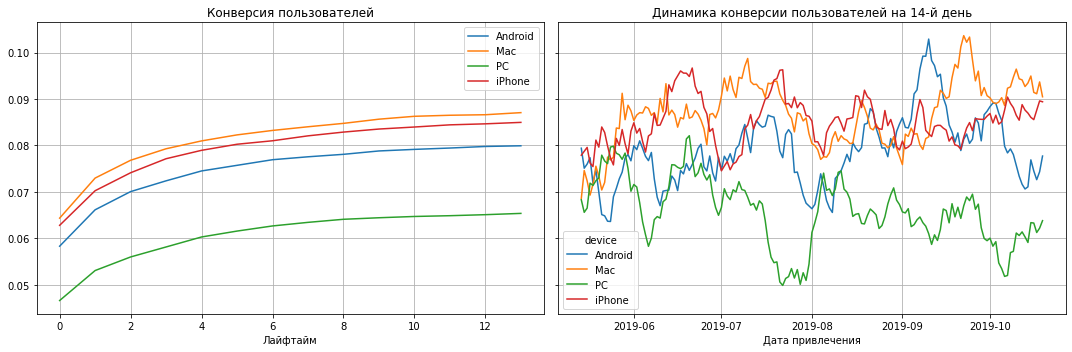

In [51]:
# и построим графики
plot_conversion(conv_device, conv_device_history, horizon_days, window=14)

По графикам конверсии видно, что в целом конверсия пользователей на Mac и iphone выше, чем по другим устройствам (к концу второй недели - чуть ниже 0,9, что выше общей конверсии по пользователям). Чуть хуже у пользователей Android. И совсем плохая конверсия пользователей PC. При этом у всех графиков 2-х недельный рост конверсии довольно слабый. В динамике за весь период видно, что имеются очень сильные скачки уровня конверсии. При этом у основных устройств (Mac и ipfone) в целом рост хоть и имеется, но довольно слабый. По android был неплохой скачок со второй половины августа до октября, но дальше вернулся на свой уровень. По PC конверсия даже наоборот слегка снижается.

In [52]:
# добавим удержание

result_raw, retention_devices, retention_devices_history = get_retention(
                                                            profiles,
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['device']
                                                            ) 
retention_devices

cohort_size    0         1         2         3         4  \
payer device                                                              
False Android        18988  1.0  0.174953  0.086476  0.051928  0.031336   
      Mac            16150  1.0  0.179195  0.085635  0.049412  0.033065   
      PC             16920  1.0  0.174704  0.087234  0.052364  0.034574   
      iPhone         29276  1.0  0.178098  0.086829  0.052774  0.034533   
True  Android         1695  1.0  0.384661  0.298525  0.250147  0.214159   
      Mac             1597  1.0  0.365059  0.284283  0.202880  0.196619   
      PC              1208  1.0  0.421358  0.333609  0.262417  0.261589   
      iPhone          2810  1.0  0.370463  0.277224  0.233808  0.193594   

                      5         6         7         8         9        10  \
payer device                                                                
False Android  0.024015  0.017485  0.013798  0.011060  0.010006  0.007742   
      Mac      0.023901  0.019505  0.014551  0.012755  0.009102  0.007988   
      PC       0.024232  0.017790  0.014539  0.011170  0.008747  0.007033   
      iPhone   0.025857  0.019436  0.014039  0.011921  0.009940  0.007310   
True  Android  0.206490  0.156342  0.166372  0.146903  0.137463  0.132743   
      Mac      0.172198  0.148403  0.142768  0.136506  0.132123  0.120852   
      PC       0.209437  0.225166  0.192053  0.175497  0.149834  0.163907   
      iPhone   0.185053  0.158363  0.144128  0.135943  0.132384  0.132028   

                     11        12        13  
payer device                                 
False Android  0.006530  0.005477  0.005056  
      Mac      0.006440  0.006254  0.004025  
      PC       0.005437  0.005851  0.005556  
      iPhone   0.006832  0.006319  0.004372  
True  Android  0.110914  0.128614  0.107375  
      Mac      0.115216  0.108954  0.110833  
      PC       0.148179  0.144040  0.124172  
      iPhone   0.120996  0.107473  0.091815

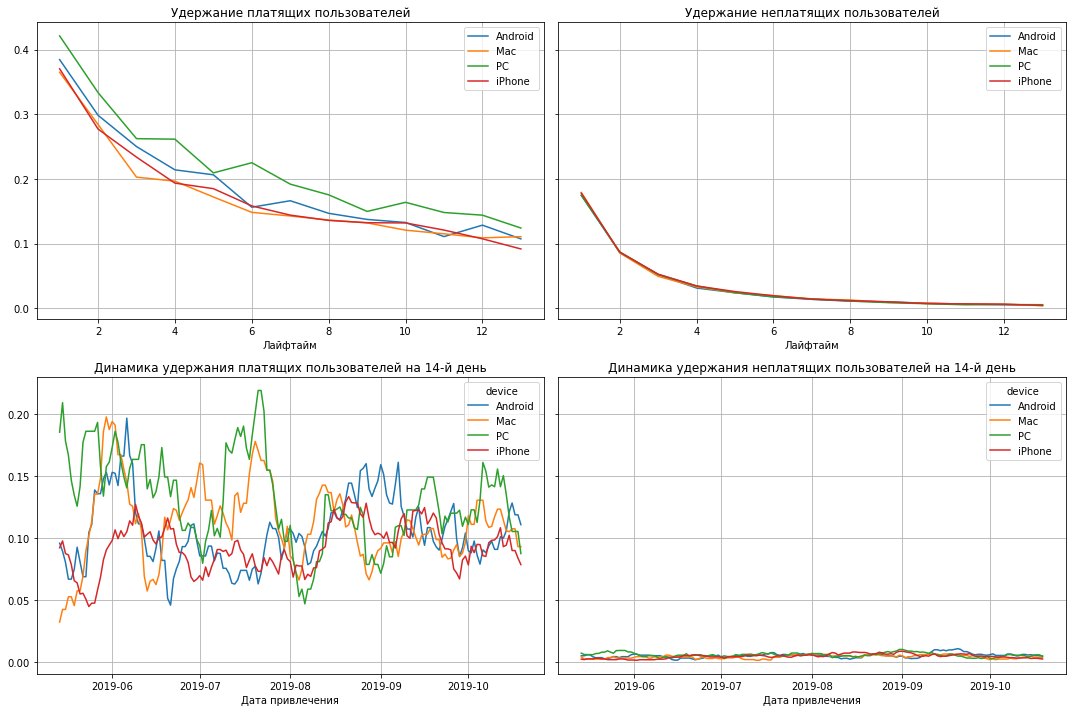

In [53]:
# графики
plot_retention(retention_devices, retention_devices_history, horizon_days, window=14)

В плане удержания платящих пользователей лучше всего результат у пользователей PC, хуже у iphone и Mac, но у всех четырёх устройств разница незначительна, и их удержание в принципе соответствует общему удержанию платящих пользователей. В первый день - удерживается примерно 40% платящих пользователей. При этом, падение удержания за две недели достаточно плавное. Сильнее всего падает удержание в первые 4 дня. Возможно было бы лучше, чтобы первые дни было бы ещё более плавное снижение удержания.  
В плане динамики за полгода видно, что имеется очень сильный разброс уровня удержания и, что у PC и MAC уровень удержания на 14-й день был выше в первой половине рассматриваемого периода, а ближе к концу у всех 4-х устройств удержание относительно выровнялось и стало в целом пониже.  
У неплатящих пользователей удержание слабое и очень быстро приближается к нулю. А в динамике уровень полностью стабилен (практически не меняется)

### Разбивка по странам

In [54]:
result_raw, ltv_region, ltv_history_region, roi_region, roi_history_region = get_ltv(
    profiles,
    orders,
    observation_date,
    horizon_days, 
    dimensions=['region']
)
display(ltv_region)
roi_region

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,
France,10516,0.193428,0.259783,0.311696,0.360199,0.406892,0.450173,0.481019,0.507213,0.541484,0.570906,0.600042,0.621870,0.649871,0.670278
Germany,9030,0.186350,0.258858,0.327945,0.375473,0.422776,0.460907,0.496938,0.534074,0.571104,0.605367,0.641507,0.665932,0.691355,0.713019
UK,10536,0.218683,0.296762,0.367626,0.416607,0.465505,0.503964,0.556090,0.585644,0.623741,0.645527,0.668830,0.692322,0.719800,0.743481
United States,58562,0.420285,0.519636,0.590981,0.651779,0.703511,0.747926,0.787655,0.825852,0.859873,0.893893,0.923530,0.950849,0.976382,1.001316


,cohort_size,cac,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,,
France,10516,0.459836,0.420645,0.564947,0.677842,0.783319,0.884863,0.978985,1.046066,1.103029,1.177559,1.241542,1.304903,1.352373,1.413265,1.457644
Germany,9030,0.464898,0.400840,0.556806,0.705411,0.807645,0.909395,0.991414,1.068917,1.148797,1.228449,1.302148,1.379887,1.432426,1.487111,1.533709
UK,10536,0.454922,0.480704,0.652335,0.808109,0.915777,1.023264,1.107802,1.222385,1.287350,1.371094,1.418984,1.470208,1.521847,1.582249,1.634306
United States,58562,1.455876,0.288682,0.356923,0.405928,0.447689,0.483222,0.513729,0.541018,0.567254,0.590622,0.613990,0.634347,0.653111,0.670649,0.687776


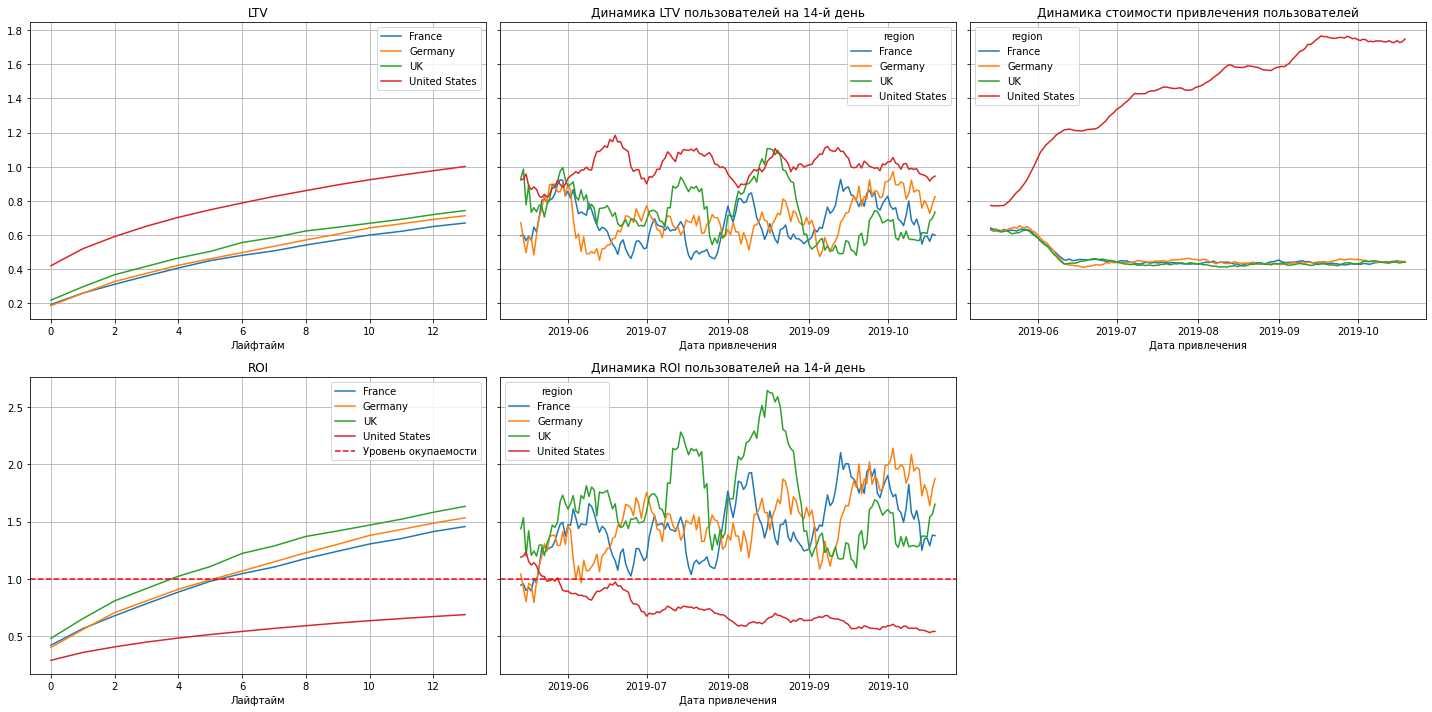

In [55]:
# графики

plot_ltv_roi(ltv_region, ltv_history_region, roi_region, roi_history_region, horizon_days, window=14)

Очень интересная картина вырисовывается в разрезе по странам:
- LTV по США однозначно выше, чем по остальным странам (приближается к 1.0у.е). По остальным странам от 0,65 до 0,75.  
- в динамике за весь период LTV 14-го дня стабильнее всего и выше опять же у США. По сравнению с началом года есть определённый, но совсем небольшой рост у США. Самая нестабильная - Германия и Великобритания. При этом Великобритания, Германия и Франция в целом остаются на +/- на одном уровне.
- при этом по ROI ситуация обратная: пользователи из Великобритании, Германии и Франции очень хорошо окупаются (причём окупаться начинают уже на 5-й - 6-й день). А вот пользователи из США не окупаются совсем.
- в динамике ROI по Германии, Великобритании и Франции хоть и имеют сильные колебания, но на протяжении всего времени остаются значительно выше единицы (т.е. хорошо окупаемыми). А вот в случае с США дела совсем плохи - уже в конце мая - начале июня пользователи из США перестали окупаться совсем.
- вероятная причина плохой окупаемости пользователей из США - резкий и значительный рост расходов на маркетинг в этой стране. CAC начал резко расти в мае и значительно превысил рекламные расходы на пользователей из других стран. По Германии, Франции и Великобритании в июне наоборот немного снизились и оставались стабильными на протяжении практически всего времени.
Далее подробней посмотрим конверсию и удержание.

С учётом того, что подавляющее число привлечённых (а также платящих) пользователей приходится на США, то такая картина с подобной динамикой LTV и CAC по данной стране выглядит критичной.

In [56]:
# Добавим расчёт конверсии для разбивки по устройствам

result_raw, conv_region, conv_region_history = get_conversion(
                                                profiles,
                                                orders,
                                                observation_date,
                                                horizon_days,
                                                dimensions=['region']
                                                )
conv_region

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
region,,,,,,,,,,,,,,,
France,10516,0.033092,0.037467,0.040985,0.042697,0.044313,0.045359,0.046120,0.046405,0.046976,0.047547,0.047642,0.048117,0.048307,0.048402
Germany,9030,0.032337,0.038760,0.041528,0.043854,0.045072,0.046512,0.047398,0.048283,0.049059,0.049612,0.049723,0.049834,0.049945,0.050498
UK,10536,0.034074,0.039104,0.042426,0.044039,0.045368,0.046412,0.047551,0.048121,0.048405,0.048595,0.048975,0.049070,0.049165,0.049165
United States,58562,0.071873,0.080650,0.084560,0.087497,0.089700,0.091032,0.092022,0.093013,0.093798,0.094566,0.095096,0.095454,0.095728,0.096069


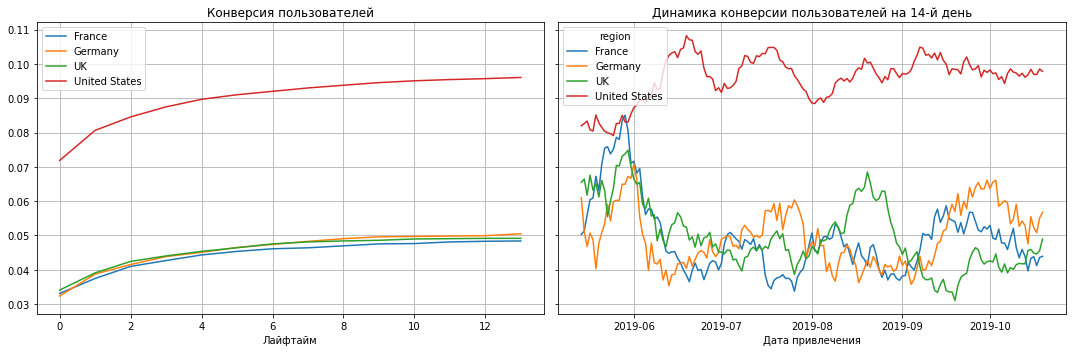

In [57]:
# и построим графики
plot_conversion(conv_region, conv_region_history, horizon_days, window=14)

По графикам конверсии видим, что:
- конверсия пользователей из США значительно выше, чем по другим странам. Однако сам по себе рост за 2 недели не самый сильный (от 0,7 до 0,96). А у остальных стран конверсия на очень низком уровне) причём все примерно в одном диапазоне)
- в динамике за весь срок получается, что с июня месяца конверсия пользователей США подросла, но далее (с середины июня и до конца октября) держалась на примерно одном уровне, что в совокупности со всё возрастающими затратами говорит о неэффективности рекламы. У остальных стран конверсия в этот период, наоборот, снизилась.

In [58]:
# добавим удержание

result_raw, retention_region, retention_region_history = get_retention(
                                                            profiles,
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['region']
                                                            ) 
retention_region

cohort_size    0         1         2         3         4  \
payer region                                                                    
False France                9993  1.0  0.173021  0.091164  0.052036  0.033724   
      Germany               8563  1.0  0.176690  0.084900  0.056172  0.035034   
      UK                   10002  1.0  0.179064  0.088582  0.051390  0.031994   
      United States        52776  1.0  0.177221  0.085626  0.051160  0.033500   
True  France                 523  1.0  0.474187  0.386233  0.323136  0.307839   
      Germany                467  1.0  0.483940  0.402570  0.314775  0.327623   
      UK                     534  1.0  0.483146  0.421348  0.327715  0.299625   
      United States         5786  1.0  0.354822  0.263913  0.212755  0.183719   

                            5         6         7         8         9  \
payer region                                                            
False France         0.022616  0.018213  0.014610  0.012108  0.010607   
      Germany        0.025225  0.019503  0.014014  0.010510  0.009926   
      UK             0.024595  0.017696  0.015897  0.011598  0.008498   
      United States  0.025030  0.018777  0.013813  0.011880  0.009474   
True  France         0.296367  0.246654  0.239006  0.223709  0.204589   
      Germany        0.284797  0.244111  0.220557  0.239829  0.211991   
      UK             0.277154  0.271536  0.247191  0.198502  0.155431   
      United States  0.166263  0.143623  0.136018  0.125475  0.122364   

                           10        11        12        13  
payer region                                                 
False France         0.007805  0.006304  0.005304  0.005504  
      Germany        0.007007  0.005722  0.006890  0.006540  
      UK             0.007299  0.006899  0.006399  0.004499  
      United States  0.007541  0.006423  0.005931  0.004301  
True  France         0.210325  0.168260  0.189293  0.173996  
      Germany        0.233405  0.173448  0.160600  0.134904  
      UK             0.168539  0.192884  0.183521  0.177903  
      United States  0.117179  0.106982  0.103007  0.089526

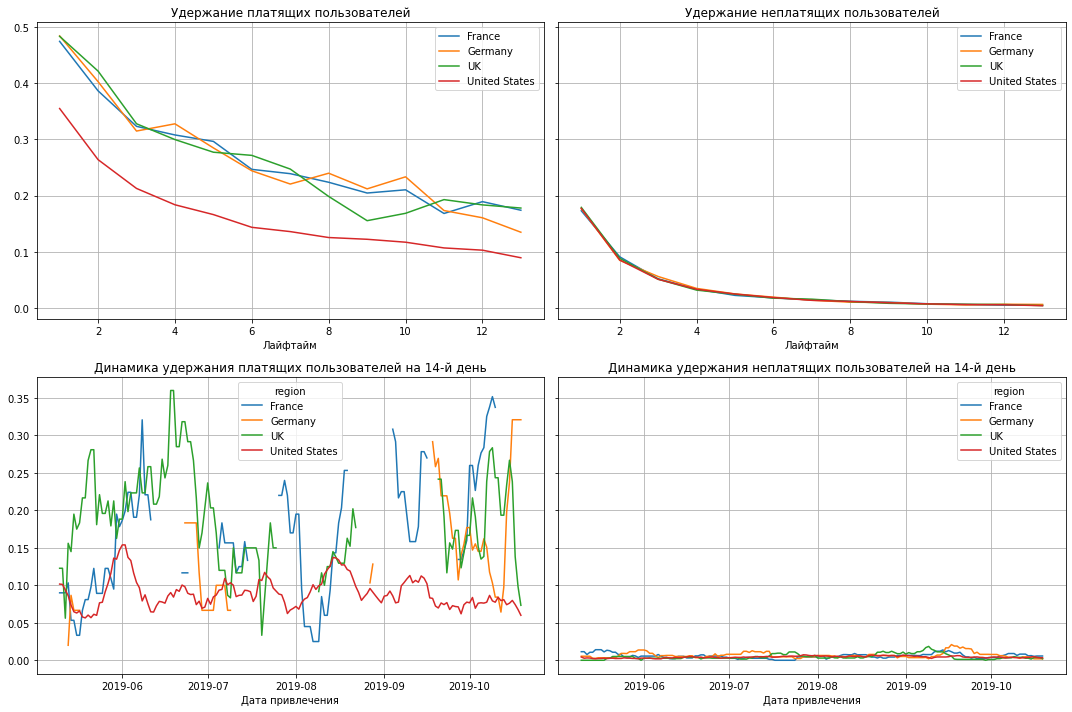

In [59]:
# графики
plot_retention(retention_region, retention_region_history, horizon_days, window=10)

По графикам удержания:
- хуже всего удержание платящих у США, а у остальных стран выше и примерно на одном уровне. Причём у США уровень удержания примерно такой как общий уровень удержания платящих пользователей без разбивки по странам, а у остальных стран даже выше общего уровня.
- в динамике видно, что на протяжении всего периода несмотря на растущие расходы на рекламу удержание платящих пользователей на 14-й день от США остаётся на том же низком уровне, в то время как у остальных стран даже при условии очень сильных колебаний уровень удержания значительно выше (хотя рекламные затраты существенно ниже) 
- у неплатящих пользователей снова та же картина - низкое удержание по всем странам, а динамике практически нет колебаний 

### разбивка по каналам привлечения

Поскольку имеется 10 рекламных источников привлечения, то для большей наглядности разобъём на две группы. Условно говоря: 6 самых популярных и 5 менее популярных среди платящих пользователей.

In [60]:
channel_users = channel_users.sort_values(by='quantity_payer', ascending=False)
channels = list(channel_users.index.unique())
channels_top = channels[:4]
channels_medium = channels[4:8]
channels_worst = channels[8:]

In [61]:
# LTV,ROI, CAC и динамика по каналам привлечения для лучших источников по количеству привлечённых платящих пользователей.
result_raw, ltv_channel_top, ltv_history_channel_top, roi_channel_top, roi_history_channel_top = get_ltv(
    profiles.query('channel in @channels_top'),
    orders,
    observation_date,
    horizon_days, 
    dimensions=['channel']
)
ltv_channel_top

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
FaceBoom,27544,0.585703,0.660825,0.700722,0.728842,0.747143,0.760369,0.774718,0.784757,0.792404,0.800775,0.806247,0.812226,0.817483,0.821469
TipTop,18498,0.343550,0.497389,0.624141,0.739834,0.842358,0.935707,1.013676,1.096450,1.171400,1.245485,1.311417,1.371467,1.427640,1.487908
WahooNetBanner,8082,0.191302,0.291477,0.378921,0.443754,0.516862,0.569469,0.631870,0.678176,0.725353,0.765488,0.812535,0.849334,0.889472,0.918615


In [62]:
# LTV,ROI, CAC и динамика по каналам привлечения для "средних" источников по количеству привлечённых платящих пользователей.
result_raw, ltv_channel_medium, ltv_history_channel_medium, roi_channel_medium, roi_history_channel_medium = get_ltv(
    profiles.query('channel in @channels_medium'),
    orders,
    observation_date,
    horizon_days, 
    dimensions=['channel']
)
ltv_channel_medium

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
AdNonSense,3702,0.505030,0.589149,0.644417,0.683509,0.706694,0.732582,0.754149,0.767628,0.789203,0.802682,0.806996,0.815084,0.827215,0.838006
LeapBob,8103,0.107048,0.155702,0.205583,0.235391,0.259654,0.288599,0.314587,0.333802,0.369543,0.394176,0.417579,0.437902,0.457608,0.473004
OppleCreativeMedia,8139,0.097239,0.131578,0.171686,0.206636,0.241103,0.266240,0.290152,0.309527,0.328544,0.346938,0.364228,0.376613,0.395017,0.409118
RocketSuperAds,4251,0.207570,0.318640,0.396114,0.455980,0.515613,0.571019,0.639125,0.687255,0.737986,0.790118,0.831437,0.864307,0.898586,0.933801


In [63]:
# LTV,ROI, CAC и динамика по каналам привлечения для "худших" источников по количеству привлечённых платящих пользователей.
result_raw, ltv_channel_worst, ltv_history_channel_worst, roi_channel_worst, roi_history_channel_worst = get_ltv(
    profiles.query('channel in @channels_worst'),
    orders,
    observation_date,
    horizon_days, 
    dimensions=['channel']
)
ltv_channel_worst

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
MediaTornado,4167,0.137485,0.191615,0.246943,0.293667,0.332249,0.366979,0.388534,0.418474,0.440034,0.461589,0.485541,0.508294,0.526256,0.533684
YRabbit,4102,0.163301,0.213423,0.256000,0.303932,0.356265,0.387894,0.414656,0.438988,0.460885,0.480349,0.502245,0.524147,0.546287,0.559668
lambdaMediaAds,2056,0.460268,0.645302,0.778789,0.905540,1.041503,1.160433,1.262369,1.352169,1.444888,1.505564,1.579348,1.630316,1.695861,1.766250


Далее построим графики для каждой группы.

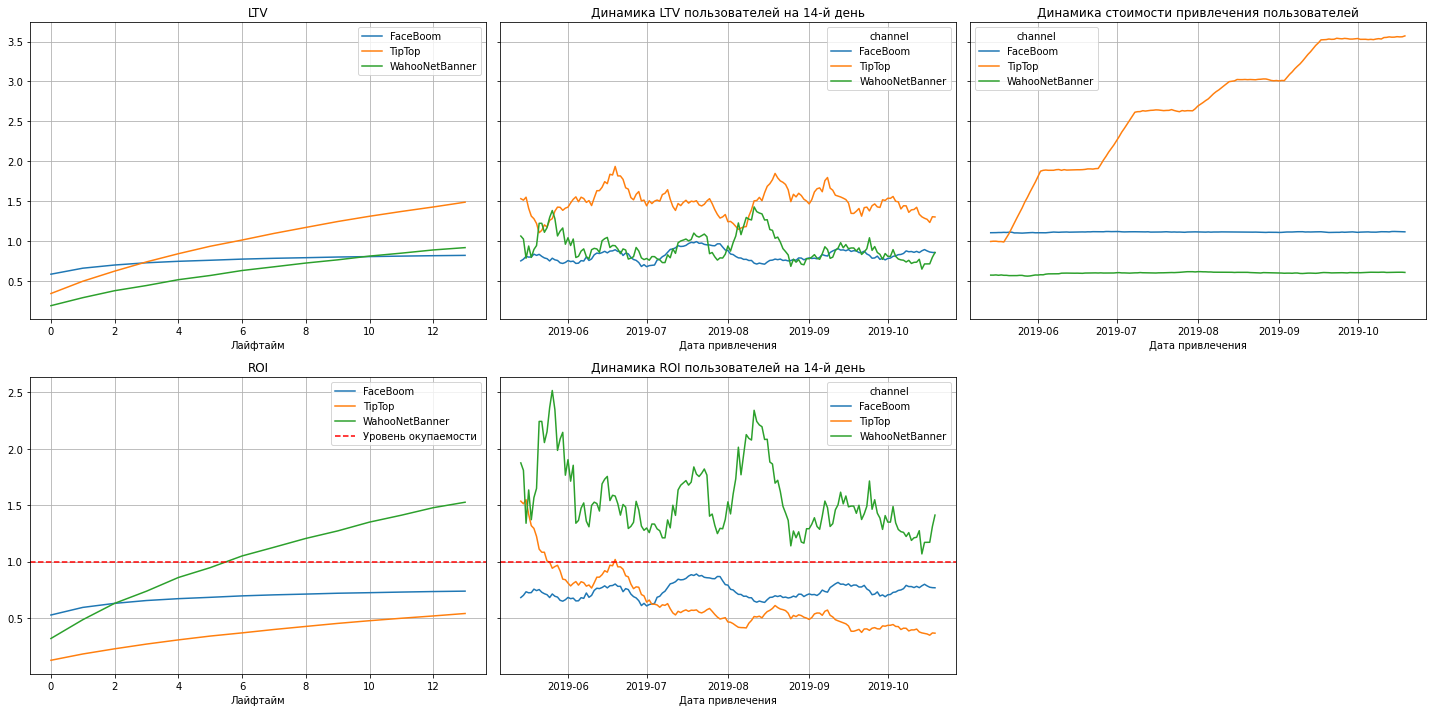

In [64]:
# графики для лучших источников

plot_ltv_roi(ltv_channel_top, ltv_history_channel_top, roi_channel_top, roi_history_channel_top, horizon_days, window=14)

Итак:
- среди рекламных источников, через которые привлекается больше всего платящих пользователей (FaceBoom, TipTop,  WahooNetBanner), наибольший LTV к исходу второй недели у TipTop. У FaceBoom хороший уровень LTV в первые дни, но зато далее кривая практически не растёт. WahooNetBanner имеет лучший уклон и под конец второй недели опережает FaceBoom. 
- Сам по себе LTV у пользователей от данных источников довольно стабильный. Сильных колебаний нет. Выше всех стабильно держится TipTop, далее примерно на одном уровне WahooNetBanner и FaceBoom, однако у WahooNetBanner были отдельные более успешные периоды (с довольно неплохими скачками)
- при этом по кривым ROI лучше всех окупается WahooNetBanner (уже на 6-7 день), а TipTop и FaceBoom не окупаются совсем.
- по динамике ROI хорошо держится также WahooNetBanner, но TipTop и FaceBoom перестали окупаться уже в конце мая-начале июня.
- и снова интересная картина по затратам: WahooNetBanner и FaceBoom имеет стабильный уровень CAC на всем рассматриваемом периоде, а у TipTop с конца мая резкий и практически непрерывный почти трехкратный рост.
Стоит вспомнить, что у FaceBoom и TipTop количество привлечённых пользователей (в т.ч. платящих), значительно больше, чем у других источников, поэтому такая ситуация критична. По WahooNetBanner привлечённых пользователей в разы меньше.


In [65]:
# Добавим расчёт конверсии для разбивки по устройствам

result_raw, conv_channel_top, conv_channel_top_history = get_conversion(
                                                profiles.query('channel in @channels_top'),
                                                orders,
                                                observation_date,
                                                horizon_days,
                                                dimensions=['channel']
                                                )
conv_channel_top

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
FaceBoom,27544,0.102091,0.109134,0.111494,0.113346,0.114762,0.115452,0.116468,0.116976,0.117557,0.118175,0.118465,0.118864,0.119082,0.119373
TipTop,18498,0.056709,0.069413,0.076062,0.080711,0.084171,0.086604,0.087685,0.089361,0.090550,0.091577,0.092334,0.092767,0.093199,0.093740
WahooNetBanner,8082,0.031180,0.038481,0.043306,0.045038,0.046894,0.048008,0.048874,0.049740,0.050359,0.051101,0.051472,0.051596,0.051720,0.052091


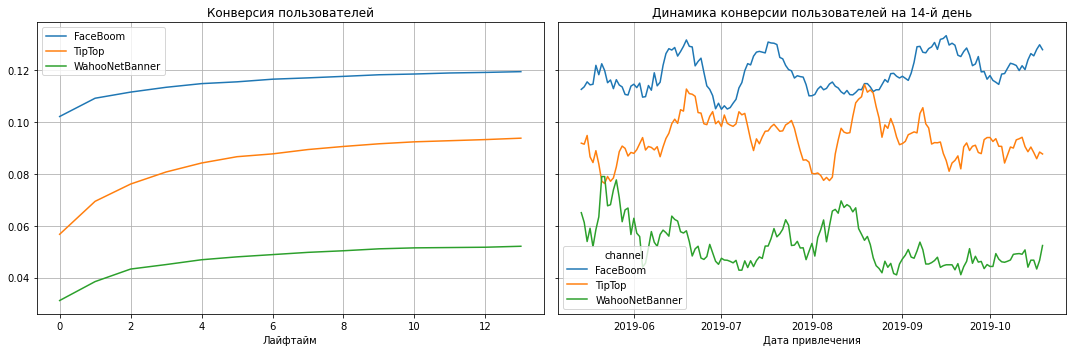

In [66]:
# и построим графики
plot_conversion(conv_channel_top, conv_channel_top_history, horizon_days, window=14)

Конверсия трёх самых лучших источников по числу платящих пользователей получается довольно разной. У Facboom самя лучшая конверсия, хотя с не самым хорошим уклоном. У TipTop конверсия ниже, а у WahooNetBanner ещё хуже. В динамике так же сочетание сохраняется на протяжении всего периода, при этом сами конверсии остаются примерно на одном уровне, хотя у TipTop очень сильный рост затрат.

In [67]:
# добавим удержание

result_raw, ret_channel_top, ret_channel_top_history = get_retention(
                                                            profiles.query('channel in @channels_top'),
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['channel']
                                                            ) 
ret_channel_top

cohort_size    0         1         2         3  \
payer channel                                                          
False FaceBoom              24182  1.0  0.172980  0.087214  0.050782   
      TipTop                16713  1.0  0.181715  0.084605  0.050859   
      WahooNetBanner         7654  1.0  0.184217  0.085446  0.053044   
True  FaceBoom               3362  1.0  0.222487  0.123141  0.075253   
      TipTop                 1785  1.0  0.532773  0.464426  0.408964   
      WahooNetBanner          428  1.0  0.553738  0.511682  0.387850   

                             4         5         6         7         8  \
payer channel                                                            
False FaceBoom        0.032710  0.025267  0.019767  0.013605  0.011910   
      TipTop          0.034943  0.026028  0.018848  0.013941  0.012086   
      WahooNetBanner  0.034492  0.022211  0.017507  0.015025  0.011759   
True  FaceBoom        0.057406  0.041344  0.038667  0.028257  0.020523   
      TipTop          0.352381  0.345658  0.288515  0.287395  0.277871   
      WahooNetBanner  0.448598  0.383178  0.338785  0.345794  0.313084   

                             9        10        11        12        13  
payer channel                                                           
False FaceBoom        0.010007  0.008064  0.005500  0.006616  0.004342  
      TipTop          0.009633  0.007240  0.006701  0.006103  0.004248  
      WahooNetBanner  0.009537  0.007055  0.006663  0.006271  0.005357  
True  FaceBoom        0.022606  0.017847  0.013682  0.012493  0.012493  
      TipTop          0.262745  0.248739  0.240896  0.225770  0.206162  
      WahooNetBanner  0.259346  0.308411  0.268692  0.252336  0.228972

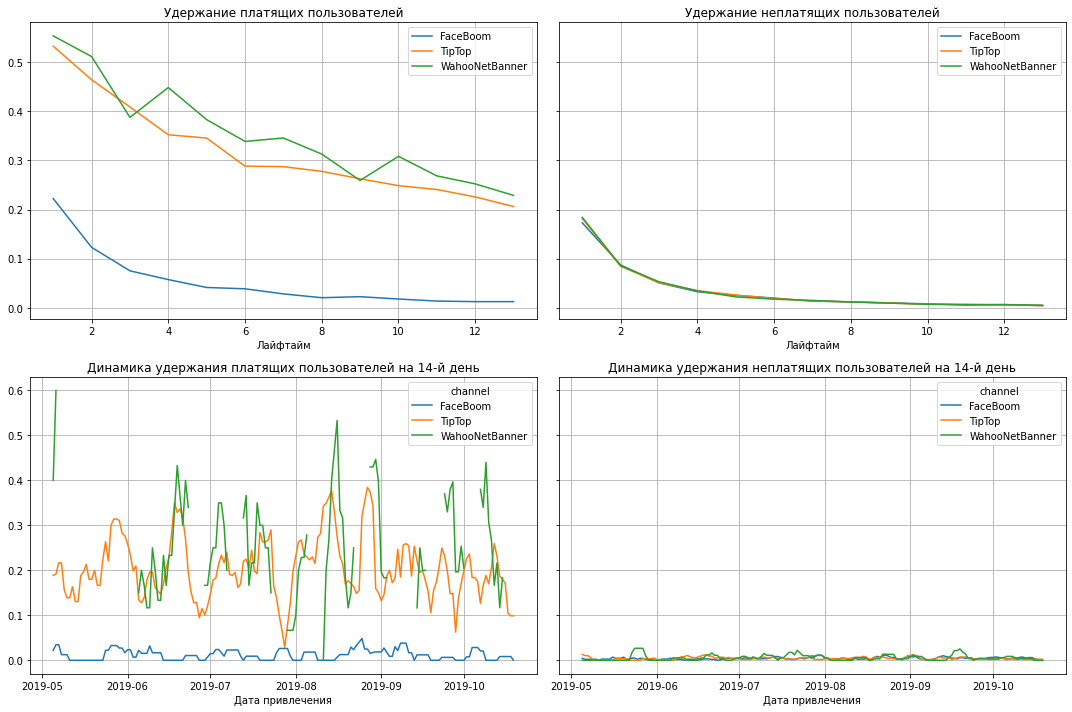

In [68]:
# графики
plot_retention(ret_channel_top, ret_channel_top_history, horizon_days, window=5)

По графикам удержания у TipTop и WahooNetBanner очень неплохое удержание платящих пользователей. А у FaceBoom удержание гораздо хуже (даже слишком низкое). По динамике FaceBoom показывает самый стабильный результат, но при этом самый низкий. У остальных уровень выше, но слишком сильный разброс.

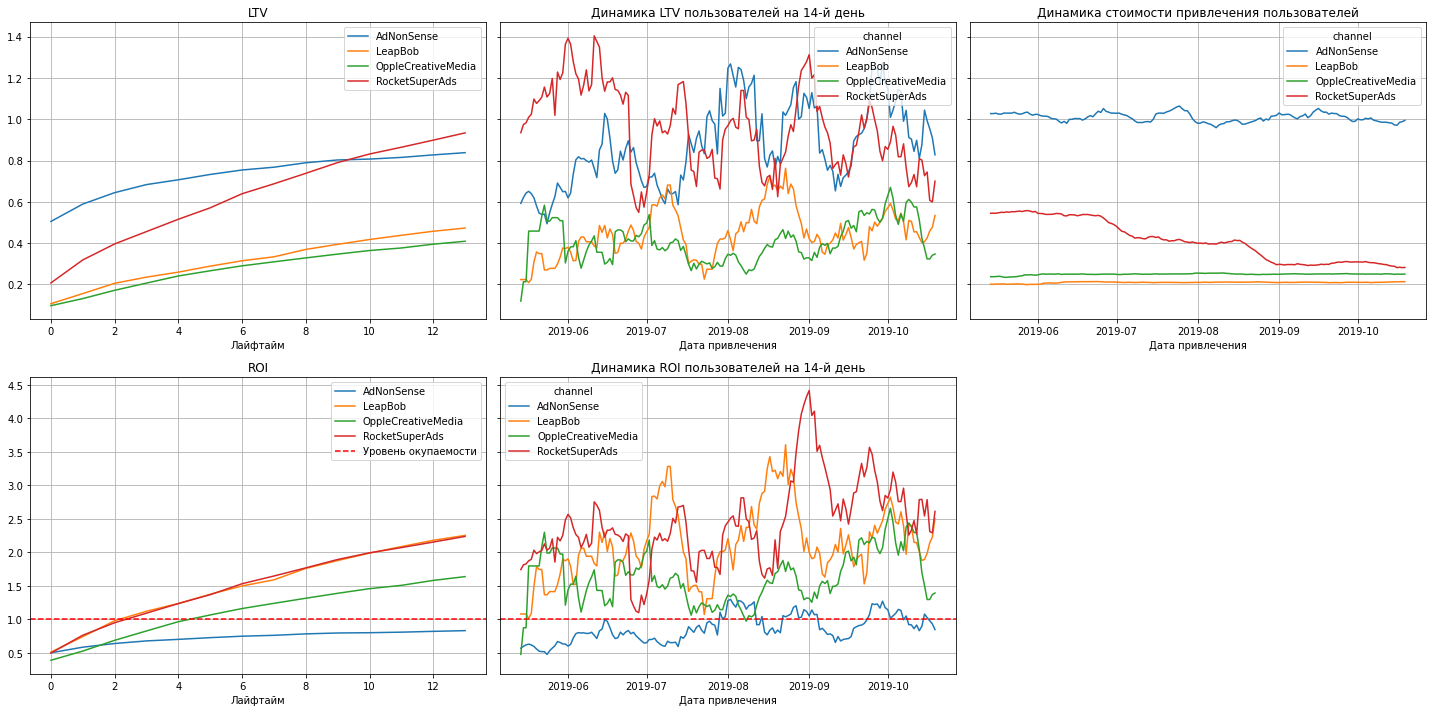

In [69]:
# графики для "средних" источников

plot_ltv_roi(ltv_channel_medium, ltv_history_channel_medium, roi_channel_medium, roi_history_channel_medium, horizon_days, window=14)

В группе средних источников (5-е - 8-е место по количеству привлечённых платящих пользователей):
- только у двух источников LTV выше 0,8у.е. но не дотягивает до (1,0у.е) - RocketSuperAds и AdNonSense. У остальных меньше 0,5.
- у данной группы на протяжении всего периода LTV подвержен очень сильным колебаниям. У RocketSuperAds в целом за последние полгода снизился. У остальных скорее наоборот - в среднем увеличился. Лучше всего картина у AdNonSense.
- при этом только как раз у AdNonSense реклама не окупается совсем. У остальных ситуация довольно хорошая (окупаются на 3-й - 5-й день)
- по сравнению с первой группой расходы на эти источники ниже, причём у RocketSuperAds расходы даже снизились. Но у AdNonSense по сравнению с 3-мя другими опять же существенно выше,  хотя пользователей привлекает примерно столько же.

In [70]:
# Добавим расчёт конверсии для разбивки по устройствам

result_raw, conv_channel_medium, conv_channel_medium_history = get_conversion(
                                                profiles.query('channel in @channels_medium'),
                                                orders,
                                                observation_date,
                                                horizon_days,
                                                dimensions=['channel']
                                                )
conv_channel_medium

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
AdNonSense,3702,0.086980,0.094003,0.096704,0.100486,0.102107,0.103998,0.105348,0.105348,0.105889,0.106159,0.106159,0.106969,0.107509,0.107509
LeapBob,8103,0.016660,0.020610,0.024065,0.025052,0.026040,0.026657,0.026904,0.027644,0.028261,0.028631,0.028878,0.029002,0.029125,0.029248
OppleCreativeMedia,8139,0.017324,0.019904,0.021501,0.023099,0.023713,0.024573,0.025310,0.025556,0.025556,0.025802,0.025925,0.026047,0.026047,0.026293
RocketSuperAds,4251,0.034110,0.047283,0.053870,0.059280,0.063750,0.065632,0.067278,0.068690,0.069866,0.071513,0.072924,0.073159,0.073394,0.073630


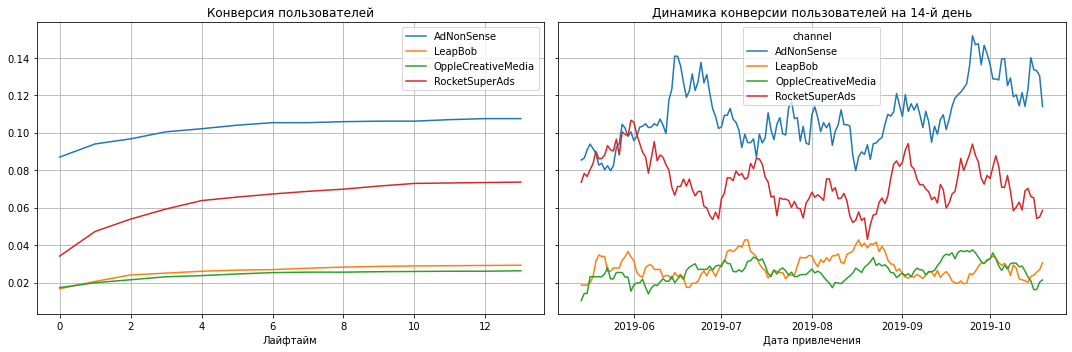

In [71]:
# и построим графики
plot_conversion(conv_channel_medium, conv_channel_medium_history, horizon_days, window=14)

По конверсии:
- выше всего в этой группе конверсия у AdNonSense. Далее - RocketSuperAds. Худший результат по конверсии показывают LeapBob	и OppleCreativeMedia.
- за весь период по уровню конверсий в этой группе существенных изменений нет. Разве что немного увеличился уровень у AdNonSense, а у RocketSuperAds, наоборот снизился. 

In [72]:
# добавим удержание

result_raw, ret_channel_medium, ret_channel_medium_history = get_retention(
                                                            profiles.query('channel in @channels_medium'),
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['channel']
                                                            ) 
ret_channel_medium

cohort_size    0         1         2         3  \
payer channel                                                              
False AdNonSense                 3289  1.0  0.176345  0.087565  0.051079   
      LeapBob                    7860  1.0  0.171120  0.091349  0.051272   
      OppleCreativeMedia         7919  1.0  0.171991  0.089026  0.053416   
      RocketSuperAds             3916  1.0  0.175179  0.085802  0.051328   
True  AdNonSense                  413  1.0  0.285714  0.162228  0.130751   
      LeapBob                     243  1.0  0.555556  0.493827  0.395062   
      OppleCreativeMedia          220  1.0  0.536364  0.459091  0.400000   
      RocketSuperAds              335  1.0  0.573134  0.468657  0.400000   

                                 4         5         6         7         8  \
payer channel                                                                
False AdNonSense          0.037093  0.021587  0.018851  0.016722  0.011250   
      LeapBob             0.032443  0.023155  0.018830  0.014504  0.010941   
      OppleCreativeMedia  0.032201  0.026266  0.019194  0.014522  0.011870   
      RocketSuperAds      0.035495  0.020684  0.015066  0.016343  0.008682   
True  AdNonSense          0.077482  0.060533  0.058111  0.048426  0.055690   
      LeapBob             0.333333  0.395062  0.288066  0.246914  0.271605   
      OppleCreativeMedia  0.395455  0.313636  0.336364  0.272727  0.236364   
      RocketSuperAds      0.394030  0.331343  0.322388  0.325373  0.262687   

                                 9        10        11        12        13  
payer channel                                                               
False AdNonSense          0.011250  0.006081  0.005473  0.006993  0.006689  
      LeapBob             0.010433  0.007252  0.006616  0.005344  0.004835  
      OppleCreativeMedia  0.008461  0.008334  0.005556  0.007198  0.005683  
      RocketSuperAds      0.007661  0.007150  0.008427  0.003830  0.002809  
True  AdNonSense          0.048426  0.016949  0.024213  0.033898  0.026634  
      LeapBob             0.251029  0.279835  0.238683  0.222222  0.209877  
      OppleCreativeMedia  0.227273  0.240909  0.222727  0.231818  0.213636  
      RocketSuperAds      0.286567  0.316418  0.226866  0.277612  0.220896

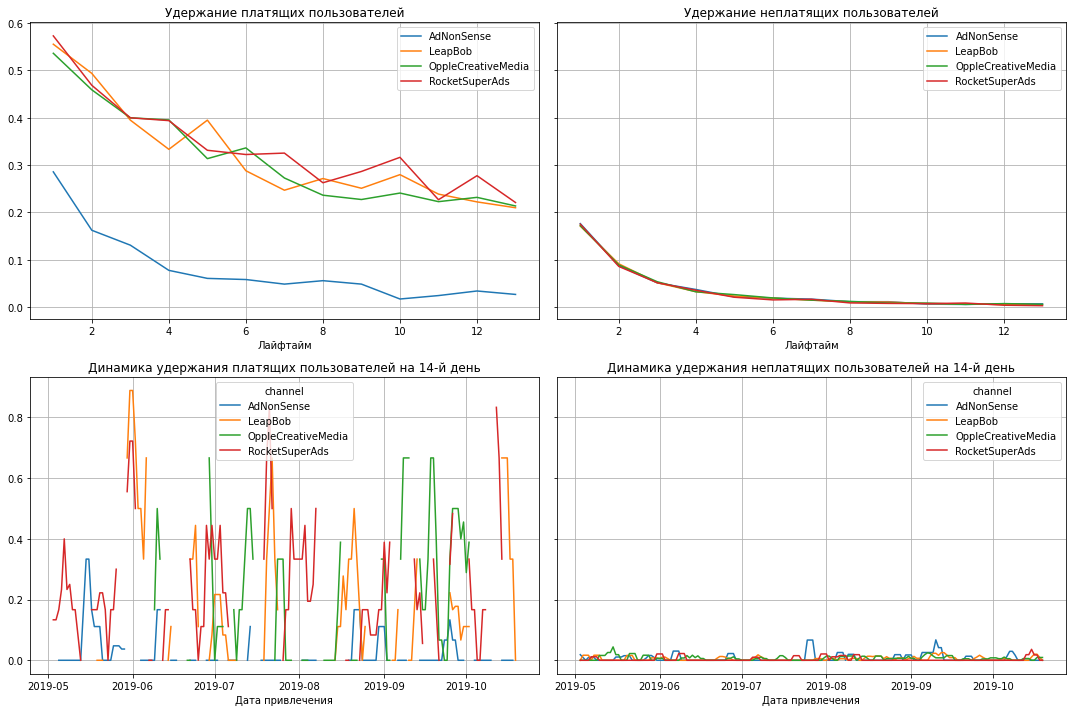

In [73]:
# графики
plot_retention(ret_channel_medium, ret_channel_medium_history, horizon_days, window=3)

В плане удержания AdNonSense показывает себя хуже всех. У остальных (LeapBob, OppleCreativeMedia, RocketSuperAds) - примерно на одном уровне и удержание даже выше общего значения удержания без деления на источники. В плане динамики - слишком сильные колебания удержания на всём периоде.

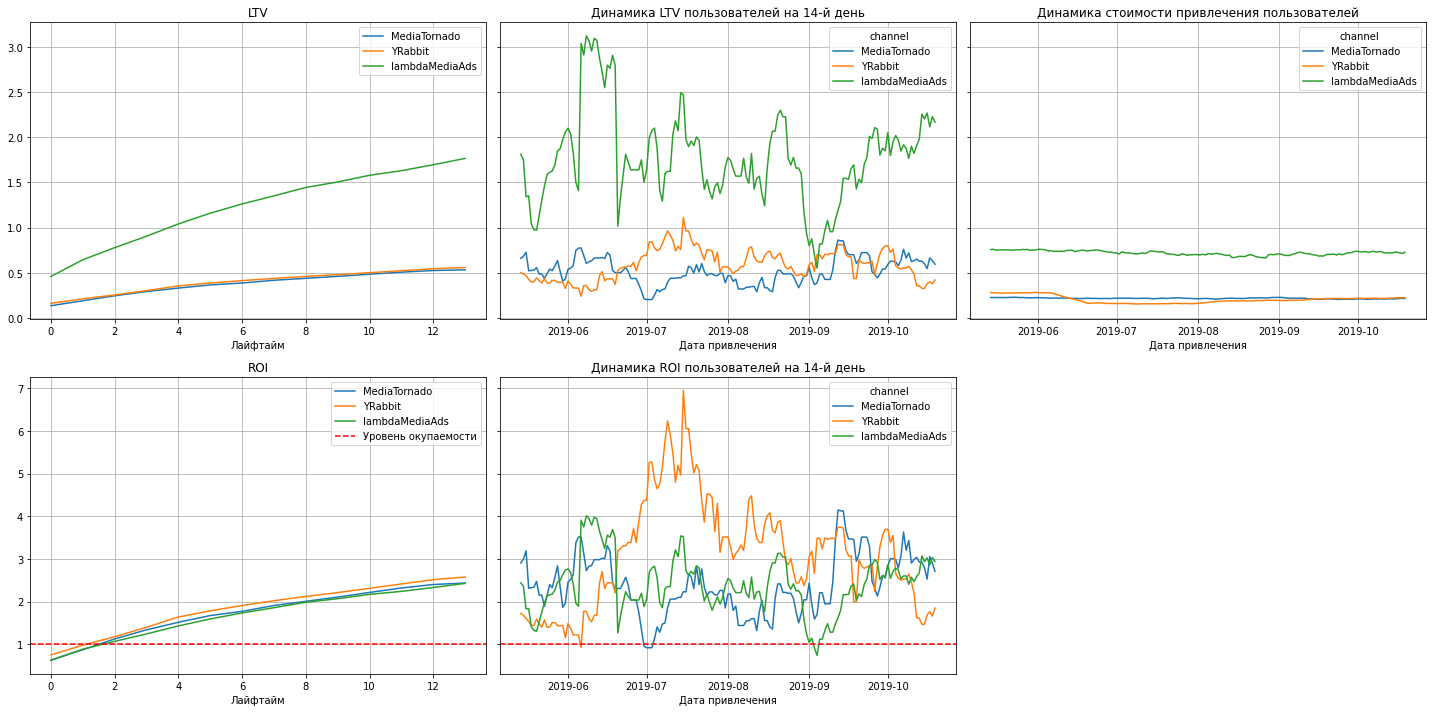

In [74]:
# графики для "худших" источников

plot_ltv_roi(ltv_channel_worst, ltv_history_channel_worst, roi_channel_worst, roi_history_channel_worst, horizon_days, window=14)

В последней группе источников, которые привлекают меньше всего платящих пользователей:
- лучший LTV у lambdaMediaAds (причём не хуже первой группы). У YRabbit и MediaTornado LTV чуть больше 0,5, что примерно на там же уровне, что и у источников второй группы. 
- в динамике за весь период у lambdaMediaAds очень сильный разброс, но в целом неплохой уровень LTV держится, у YRabbit и MediaTornado колебаний почти нет, но уровень существенно ниже.
- при этом все 3 источника одинаково хорошо окупаются (уже на 3-й день)
- расходы держатся на одном уровне.

In [75]:
# Добавим расчёт конверсии для разбивки по устройствам

result_raw, conv_channel_worst, conv_channel_worst_history = get_conversion(
                                                profiles.query('channel in @channels_worst'),
                                                orders,
                                                observation_date,
                                                horizon_days,
                                                dimensions=['channel']
                                                )
conv_channel_worst

,cohort_size,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0
channel,,,,,,,,,,,,,,,
MediaTornado,4167,0.023278,0.027358,0.028078,0.029998,0.030478,0.031198,0.031198,0.032397,0.032637,0.032637,0.033357,0.033357,0.033357,0.033357
YRabbit,4102,0.025841,0.028766,0.031204,0.032179,0.033398,0.034130,0.034861,0.035349,0.035836,0.036324,0.036324,0.036568,0.036811,0.037055
lambdaMediaAds,2056,0.072471,0.081712,0.085117,0.088521,0.092412,0.095817,0.099708,0.100681,0.102626,0.103113,0.103113,0.103599,0.103599,0.103599


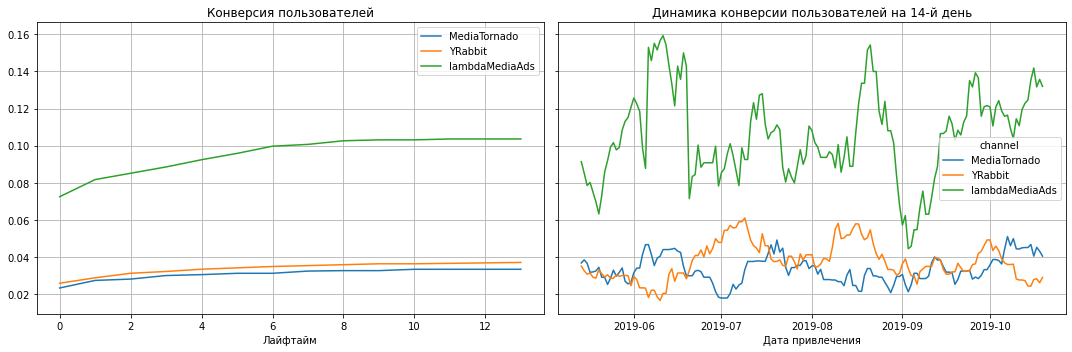

In [76]:
# и построим графики
plot_conversion(conv_channel_worst, conv_channel_worst_history, horizon_days, window=14)

В группе худших рекламных источников по количеству платящих пользователей по конверсии лучше всего себя показывает lambdaMediaAds. У YRabbit и MediaTornado картина значительно хуже (не дотягивают даже до 0,04). За весь период Остаются примерно на одном уровне lambdaMediaAds держится стабильно выше, но с сильными перепадами, у YRabbit и MediaTornado уровень существенно ниже но стабильней.

In [77]:
# добавим удержание

result_raw, ret_channel_worst, ret_channel_worst_history = get_retention(
                                                            profiles.query('channel in @channels_worst'),
                                                            visits,
                                                            observation_date,
                                                            horizon_days,
                                                            dimensions=['channel']
                                                            ) 
ret_channel_worst

cohort_size    0         1         2         3  \
payer channel                                                          
False MediaTornado           4019  1.0  0.183130  0.082359  0.056482   
      YRabbit                3946  1.0  0.180182  0.083376  0.049164   
      lambdaMediaAds         1836  1.0  0.183007  0.086601  0.062636   
True  MediaTornado            148  1.0  0.500000  0.452703  0.351351   
      YRabbit                 156  1.0  0.564103  0.384615  0.397436   
      lambdaMediaAds          220  1.0  0.563636  0.490909  0.395455   

                             4         5         6         7         8  \
payer channel                                                            
False MediaTornado    0.028614  0.024882  0.018661  0.011694  0.015924   
      YRabbit         0.035226  0.023822  0.016219  0.014192  0.009883   
      lambdaMediaAds  0.033224  0.031046  0.016340  0.014161  0.010893   
True  MediaTornado    0.344595  0.351351  0.250000  0.229730  0.216216   
      YRabbit         0.371795  0.275641  0.262821  0.230769  0.262821   
      lambdaMediaAds  0.372727  0.372727  0.340909  0.327273  0.272727   

                             9        10        11        12        13  
payer channel                                                           
False MediaTornado    0.008460  0.007216  0.008957  0.004479  0.004976  
      YRabbit         0.008363  0.006336  0.006336  0.004562  0.005068  
      lambdaMediaAds  0.009259  0.007625  0.008715  0.003268  0.005447  
True  MediaTornado    0.175676  0.229730  0.229730  0.162162  0.121622  
      YRabbit         0.262821  0.217949  0.211538  0.217949  0.102564  
      lambdaMediaAds  0.213636  0.222727  0.181818  0.204545  0.190909

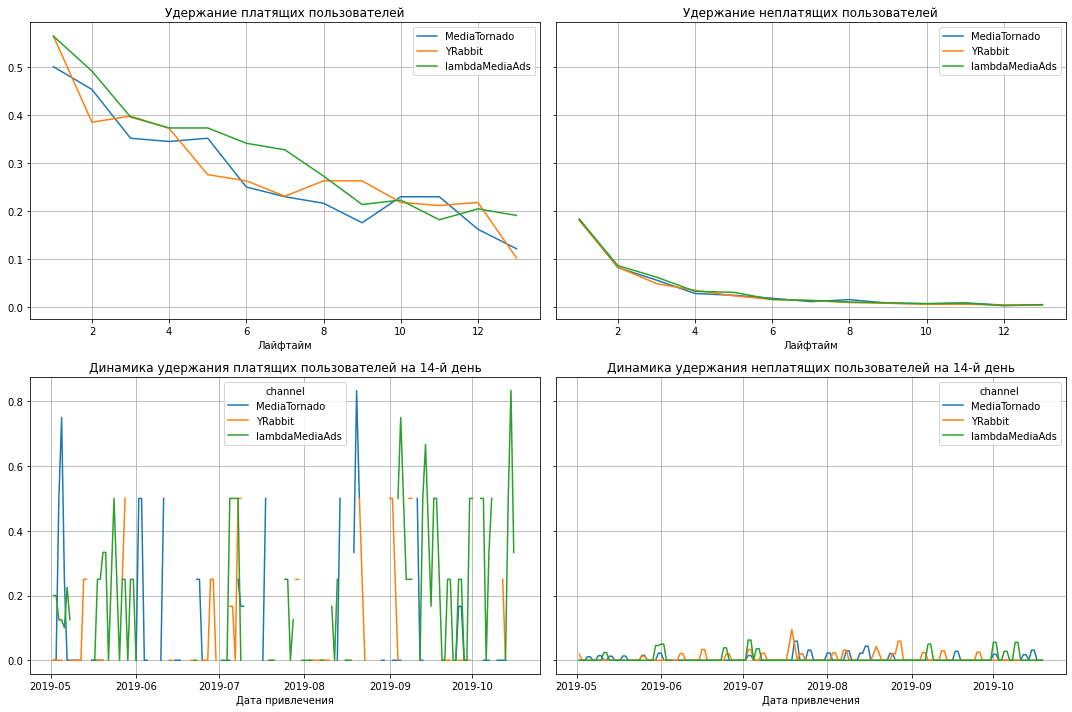

In [78]:
# графики
plot_retention(ret_channel_worst, ret_channel_worst_history, horizon_days, window=2)

По удержанию в данной группе все три источника держатся примерно на одном достаточно хорошем уровне, но уклон кривых довольно сильный. В течение полугода разброс достаточно большой. 

### Итого по разделу:
1) Реклама не окупается. К концу второй недели ROI пользователя еле дотягивается до единицы. За полгода есть чёткая тенденция к снижению уровня ROI. LTV за полгода относительно стабилен, но имеются колебания, и в то же время сильно растут расходы на рекламу.   
2) в разрезе по используемым устройствам видно, что пользователи с MAC и iphone не окупаются за две недели. Также не окупается и Android. И это при том, что на эти устройства приходится больше всего платящих пользователей. И напротив, пользователи PC окупаются значительно лучше. Однако по всем видам устройств имеется негативная тенденция к снижению ROI   
3) при этом конверсия пользователй от MAC и iphone выше, чем по другим устройствам (Хуже всего у PC). И рост конверсии за две недели не самый лучший. В динамике рост хоть и имеется у основных устройств (Mac и ipfone), но он довольно слабый.  
4) по удержанию лучше всего результат у пользователей PC, хуже у iphone и Mac, но у всех четырёх устройств разница незначительна. За полгода у всех 4-х устройств выровнялось и слегка снизилось  
5) в разрезе по странам хуже всего ситуация у США - реклама не окупается совсем. Причём на долю США приходится подавляющее число пользователей. Напротив, в остальных странах реклама окупается гораздо лучше - уже на 5-6-й день. По США конверсия пользователей значительно выше, чем по другим странам (в остальных 3-х странах уровень конверсии слишком низкий). При этом конверсия в США подросла, но совсем немного. Хуже всего удержание платящих у США, а у остальных стран выше и примерно на одном уровне.
4) в случае с источниками привлечения - у наиболее популярных источников (FaceBoom и TipTop) несмотря на большое количество привлечённых пользователей, реклама не окупается. Также у другого источника AdNonSense также не окупается несмотря на хороший процент платящих пользователей. у остальных же источников ситуация гораздо лучше - окупаются очень быстро (окупаются на 3-5-й день).  
5) возможные проблемы окупаемости:  
   а) во многих случаях где реклама не окупалась (или имелась явная тенденция к снижению ROI) заметно явное увеличению расходов на рекламу как в целом, так и в разрезе по категориям, при отсутствии достаточного эффекта:  
    - так в случа с разбивкой по странам у США расходы на рекламу выросли более,чем в 3 раза, хотя у других стран расходы выросли незначительно.  В то же время LTV по данной стране заметного роста не показал. При этом у днной страны й самое низкое удержание из всех стран. А за полгода таких больших расходов уровень удрежания или конверсии существенного роста не показали. Т.е. привлекая так много клиентов, фактический эффект в виде достаточного количества покупателей и совершённых ими покупок не достигается.
    - в разбивке по устройствам расходы на привлечение пользователей растут по всем видам устройств, но сильнее всего на Mac и iphone. При этом LTV роста не показывает.  Также нет существенного роста за полгода и уровня конверсии, а удержание остаётся в лучшем случае на том же уровне.
    - в разбивке по источникам привлечения наибольшие расходы на рекламу идут на те источники, где привлекается больше всего польователей и где выше процент платящих, однако именно в этих источниках реклама, вероятно, слишком дорогая и не окупается при том, что LTV не растёт.  Туде же можно при не самой плохой конверсии удержание оказывается слишком слабым (например, особенно в случае с FaceBoom и AdNonSense).  
   б) Т.е. стоит обратить внимание, чтов целом при таком сильном увеличении рекламных расходов конверсия привлечённых пользователей в платящих за двух-недельный срок растёт слишком медленно (с 6% до 8%). При этом в динамике за полгода рост имеется только в первые два месяца, а дальше относитально стабильна. А удержание вообще роста не показывает. Кроме того, и в разрезе, например, источников привлечения можно заметить, что менее популярные источники показывают очень слабую конверсию при не самом плохом удержании, что тоже может говорить  об неэффективности рекламы.
   в) наконец, нельзя не отметить, что удержание привлечённых пользователей из неплатящих очень слабое, причём даже в первые дни (из-за чего, возможно слишком мало пользователей переходит позднее в категорию "платящих")   

## Выводы
Итак:
1) общее
- на вход получены датасеты `visits` c данными о посещениях сервиса, `orders` c данными о покупках и 'costs' с данными о затратах на маркетинг. Наименование столбцов приведены в более корректный стиль. Исправлен тип данных в столбцах с датами и временем. Дубликатов нет
- Привлекаются пользователи из 4-х стран: США, Великобритании, Франции и Германии. Больше всего пользователей из США. Также из этой страны больше всего и платящих пользователей (также и процент платящих к привлечённым - 6,90%, у остальных - около 4%).
- Основные используемые устройства - iphone, Mac, PC и устройства на Android. Наибольшей популярностью среди платящих покупателей - iphone. Меньше всего пользователей используют PC. Доля платящих у iphone и Mac - выше 6%, у PC и Android - 5,05% и 5,85% соответственно
- имеется 10 источников привлечения, на которые направлен рекламный бюджет, а также "органические" пользователи, которые приходят сами. Больше всего платящих пользователей приходится на FaceBoom и TipTop, а также много "органических". Наибольшая доля платящих среди привлечённых у FaceBoom (12,20%), AdNonSense(11,34%), lambdaMediaAds (10,47%) и TipTop (9,60%). При этом у AdNonSense и lambdaMediaAds количество привлечённых пользователей совсем небольшое (суммарно 6029 пользователей).Разброса процента платящих пользователей по отношению к привлечённым в разрезе источников привлечения очень сильный (от 2,02% до 12,2%)

2) плохая окупаемость 
- реклама не окупается. К концу второй недели ROI пользователя еле перешагнул 0,8. Также за полгода есть чёткая тенденция к снижению уровня ROI. LTV за полгода относительно стабилен, но имеются колебания, и в то же время очень сильно растут расходы на рекламу.
- в разрезе по используемым устройствам - пользователи с MAC, iphone а также Android не окупаются за две недели (на эти устройства приходится больше всего платящих пользователей). И, напротив, пользователи PC окупаются значительно лучше. Однако по всем видам устройств имеется негативная тенденция к снижению ROI. 
- в разрезе по странам хуже всего ситуация у США - реклама не окупается совсем. Причём на долю США приходится подавляющее число пользователей. Напротив, в остальных странах реклама окупается гораздо лучше - уже на 5-6-й день. 
- источники привлечения - у наиболее популярных источников (FaceBoom и TipTop) несмотря на большое количество привлечённых пользователей, реклама не окупается. У AdNonSense также не окупается несмотря на хороший процент платящих пользователей. у остальных же источников ситуация гораздо лучше - окупаются очень быстро (окупаются на 3-6-й день). 

3) Причины плохой окупаемости:
- возможно, слишком большие и неоправданные затраты на рекламу (на отдельные направления слишком большие расходы и слишком сильный рост за полгода) - например, слишком большой рост расходов на США (в разрезе по странам), Mac и iphone (в разрезе по устройствам) и TipTop (по каналам привлечения).  
- возможно, неэффективное и несоразмерное распределение рекламного бюджета по направлениям - слишком сильный упор сделан на те категории, которые привлекают больше всего платящих пользователей, но не повышает значительно отдачу от каждого пользователя в отдельности. При этом по самым популярным источникам (TipTop, FaceBoom и AdNonSense) каждый отдельный пользователь обходится слишком дорого. В то же время у менее популярных платформ рекламный бюджет не меняется.   
- кроме того, неэффективность также отражается в том, что вероятно в первую очередь упор сделан в большей степени именно на привлечение пользователей, а не на увлечение конверсии или улучшение удержания платящих пользователей (как в целом, так и по категориям). Так конверсия за рассматриваемый период выросла не слишком сильно, а за две недели конверсия растёт всего на 1,5-2%. При этом нельзя не обратить внимание на то, что очень слабое удержание неплатящих пользователей, при том, что в общем доля платящих - всего около 6%. Если смотреть глубже, то:    
   ~ по устройствам: конверсия у MAC и iphone выше, чем у Android и PC, однако за полгода существенного роста, даже при таком увеличении вложений в рекламу не наблюдается. При этом удержание в лучшем случае, остаётся на том же уровне.      
   ~ по странам: конверсия пользователей значительно лучше у США, а у других стран гораздо ниже. При этом те же США показывают худшее среди стран удержание.  
   ~ по источникам привлечения: конверсия у топовых источников, возможно и неплохая, но удержание (в частности, у FaceBoom) очень слабое. В то время как у менее популярных источников удержание значительно выше.  
  Также почти во всех случаях не наблюдается существенного роста уровня удержания за последние полгода несмотря на увеличение расходов на рекламу.  

4) возможные рекомендации: 
- пересмотр размера бюджета (и его направленность), направленного на особо популярные, но неэффективные категории:    
  a) по устройствам — это MAC и iphone (в то же время по остальным устройствам также необходимо скорректировать размер и направленность трат на рекламу, т.к. имеются негативные тенденции)  
  b) по странам - США  
  c) по источникам — это TipTop, FaceBoom и AdNonSense  
  Во всех случаях необходимо сократить размер бюджета и направить усилия на улучшение ситуации с держанием клиентов, а также по возможности на увеличения уровня конверсии. 
- перераспределение части бюджета в пользу более эффективных и дешёвых категорий. Например, уделить больше внимания на привлечение пользователей из Европы (Германии, Франции и Великобритании), т.к. они имеют показывают хорошую окупаемость при небольших расходах, при этом имеют хорошую конверсию и неплохое удержание.  Возможно, стоит рассмотреть увеличение расходов на привлечение пользователей на рекламу через более эффективные рекламные источники, например (в первую очередь): RocketSuperAds, WahooNetBanner и lambdaMediaAds, т.к. они также показывают хорошую окупаемость и неплохую конверсию.
- сконцентрироваться в целом на увеличении общего уровня конверсии в платящих пользователей и увеличении роста конверсии за 2 недели и рассмотреть возможность улучшения удержания пользователей в категорию "платящих")   